# Machine Learning Based Traffic Analysis of Video Conferencing Services in rural communities - Main

# 📚 | Import Libraries

In [1]:
import keras_cv
import keras
from keras import ops
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import joblib
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt

## Library Versions

In [2]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasCV:", keras_cv.__version__)

TensorFlow: 2.16.1
Keras: 3.3.3
KerasCV: 0.9.0


# 💾 | Data Preparation

## Initial Inspection

### The Zoom480pRaw Dataset contains the following QoS metrics :

#### 1. Local time : The timestamp indicating when the data was captured.
#### 2. Download (Rx) bandwidth (bps) : The bandwidth available for downloading data, measured in bits per second (bps).
#### 3. Upload (Tx) bandwidth (bps) : The bandwidth available for uploading data, measured in bits per second (bps).
#### 4. Rx packet loss (percent) : Percentage of packets lost during download.
#### 5. Tx packet loss (percent) : Percentage of packets lost during upload.
#### 6. RTT (ping) (ms : Round Trip Time (RTT) measures the time (in milliseconds) for a signal to travel to the server and back.
#### 7. Rx instant jitter (ms) : Instantaneous jitter during download, measured in millisecond
#### 8. Tx instant jitter (ms) : Instantaneous jitter during upload, measured in milliseconds.
#### 9. Rx RFC3550 jitter (ms) : Jitter measured according to the RFC3550 standard for downloading packets.
#### 10.Tx RFC3550 jitter (ms) : Jitter measured according to the RFC3550 standard for uploading packets
#### 11.Rx packet loss burst length (packets) : The number of consecutive packets lost during download.
#### 12.Tx packet loss burst length (packets) : The number of consecutive packets lost during upload.


#### 13.Download bandwidth &
#### 14.Upload Bandwidth : These columns represent textual descriptions of bandwidth values in a human-readable format, such as 2.08 bps/4.00 bps.

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Load the dataset
file_path = '/kaggle/input/zoom480p/zoom480pRaw.csv'  # Update this path based on your Kaggle dataset location
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print("First few rows of the dataset:")
display(data.head())

# Display basic information about the dataset
print("\nDataset Info:")
data.info()

# Check for missing values
print("\nMissing Values per Column:")
print(data.isnull().sum())

# Display summary statistics
print("\nSummary Statistics:")
display(data.describe())


First few rows of the dataset:


,Local time,Download (Rx) bandwidth (bps),Download bandwidth,Rx packet loss (percent),Upload (Tx) bandwidth (bps),Upload bandwidth,Tx packet loss (percent),RTT (ping) (ms),Rx packet loss burst length (packets),Tx packet loss burst length (packets),Rx instant jitter (ms),Tx instant jitter (ms),Rx RFC3550 jitter (ms),Tx RFC3550 jitter (ms)
0,22-11-2023 17:29,2180459.5,2.08Mbps/4.00Mbps,0.391257,2095309.0,2.00Mbps/2.00Mbps,0.015329,76.0,1.999964,2.000007,13.937400,41.205400,7.645997,12.341899
1,22-11-2023 17:29,2248265.8,2.14Mbps/4.00Mbps,0.000008,2091075.0,1.99Mbps/2.00Mbps,0.017393,49.0,2.004499,2.000006,13.645300,42.226900,7.118157,11.712419
2,22-11-2023 17:29,2260864.2,2.16Mbps/4.00Mbps,0.000010,2091325.8,1.99Mbps/2.00Mbps,0.022528,49.0,2.004499,2.000006,11.302199,35.522100,7.314697,10.271344
3,22-11-2023 17:29,2241506.5,2.14Mbps/4.00Mbps,0.000013,2093249.1,2.00Mbps/2.00Mbps,0.028613,61.0,2.004499,2.000007,15.900100,43.328598,7.379264,11.401575
4,22-11-2023 17:29,2267823.2,2.16Mbps/4.00Mbps,0.000016,2096676.4,2.00Mbps/2.00Mbps,0.032748,48.0,2.004499,2.000007,13.352600,44.489800,7.549689,12.029810



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 14 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Local time                             729 non-null    object 
 1   Download (Rx) bandwidth (bps)          729 non-null    float64
 2   Download bandwidth                     729 non-null    object 
 3   Rx packet loss (percent)               729 non-null    float64
 4   Upload (Tx) bandwidth (bps)            729 non-null    float64
 5   Upload bandwidth                       729 non-null    object 
 6   Tx packet loss (percent)               729 non-null    float64
 7   RTT (ping) (ms)                        729 non-null    float64
 8   Rx packet loss burst length (packets)  729 non-null    float64
 9   Tx packet loss burst length (packets)  729 non-null    float64
 10  Rx instant jitter (ms)                 729 non-null    floa

,Download (Rx) bandwidth (bps),Rx packet loss (percent),Upload (Tx) bandwidth (bps),Tx packet loss (percent),RTT (ping) (ms),Rx packet loss burst length (packets),Tx packet loss burst length (packets),Rx instant jitter (ms),Tx instant jitter (ms),Rx RFC3550 jitter (ms),Tx RFC3550 jitter (ms)
count,7.290000e+02,729.000000,7.290000e+02,7.290000e+02,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000
mean,2.141659e+06,0.365736,2.090474e+06,5.370571e-03,60.315989,1.420049,0.601510,17.623750,45.263511,7.360208,11.536054
std,1.976289e+05,0.654023,1.538648e+04,3.084224e-02,17.524060,0.550051,0.979640,11.635208,29.746005,1.825422,3.023425
min,8.913121e+05,0.000000,1.846313e+06,0.000000e+00,36.000000,0.000000,0.000000,0.652100,0.500000,3.646425,5.792518
25%,2.049401e+06,0.000035,2.090931e+06,0.000000e+00,50.000000,1.076822,0.000000,13.376300,29.455100,6.478156,9.351850
50%,2.183379e+06,0.014022,2.094055e+06,0.000000e+00,57.000000,1.504040,0.000000,15.763100,36.600098,7.340136,10.855251
75%,2.269906e+06,0.452934,2.096313e+06,2.330000e-10,66.000000,1.803219,0.500000,18.798600,51.554800,7.964654,12.675699
max,2.456452e+06,3.727192,2.097152e+06,4.254852e-01,195.620390,3.000000,2.500014,126.406494,409.229000,20.897910,36.682903


## Redundancy Checking between Rx and Tx metrics.



Correlation Matrix for Rx and Tx Metrics:
                          Rx packet loss (percent)  Tx packet loss (percent)  \
Rx packet loss (percent)                  1.000000                 -0.095837   
Tx packet loss (percent)                 -0.095837                  1.000000   
Rx instant jitter (ms)                    0.066013                  0.004015   
Tx instant jitter (ms)                   -0.145542                 -0.003814   

                          Rx instant jitter (ms)  Tx instant jitter (ms)  
Rx packet loss (percent)                0.066013               -0.145542  
Tx packet loss (percent)                0.004015               -0.003814  
Rx instant jitter (ms)                  1.000000                0.268407  
Tx instant jitter (ms)                  0.268407                1.000000  


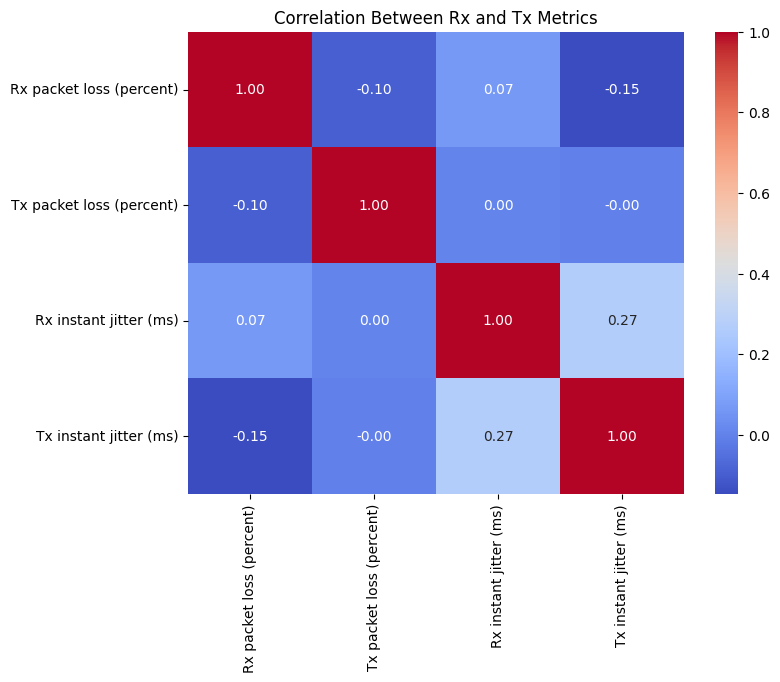

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlations between Rx and Tx metrics
rx_tx_correlations = data[[
    'Rx packet loss (percent)', 'Tx packet loss (percent)',
    'Rx instant jitter (ms)', 'Tx instant jitter (ms)'
]].corr()

# Display the correlation matrix
print("\nCorrelation Matrix for Rx and Tx Metrics:")
print(rx_tx_correlations)

# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rx_tx_correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Rx and Tx Metrics')
plt.show()


### The low correlation values indicate that Rx and Tx metrics do not show significant redundancy. This suggests that both metrics capture different aspects of the network's QoS and should be retained. There is no strong redundancy between Rx and Tx jitter or packet loss. Hence, both sets of metrics can provide unique value for analyzing the dataset.

## Redundancy checking between RFC3550 jitter (ms) & Instant Jitter (ms)

Correlation Matrix for Jitter Metrics:
                        Rx instant jitter (ms)  Tx instant jitter (ms)  \
Rx instant jitter (ms)                1.000000                0.268407   
Tx instant jitter (ms)                0.268407                1.000000   
Rx RFC3550 jitter (ms)                0.674260                0.351089   
Tx RFC3550 jitter (ms)                0.212403                0.884349   

                        Rx RFC3550 jitter (ms)  Tx RFC3550 jitter (ms)  
Rx instant jitter (ms)                0.674260                0.212403  
Tx instant jitter (ms)                0.351089                0.884349  
Rx RFC3550 jitter (ms)                1.000000                0.368488  
Tx RFC3550 jitter (ms)                0.368488                1.000000  


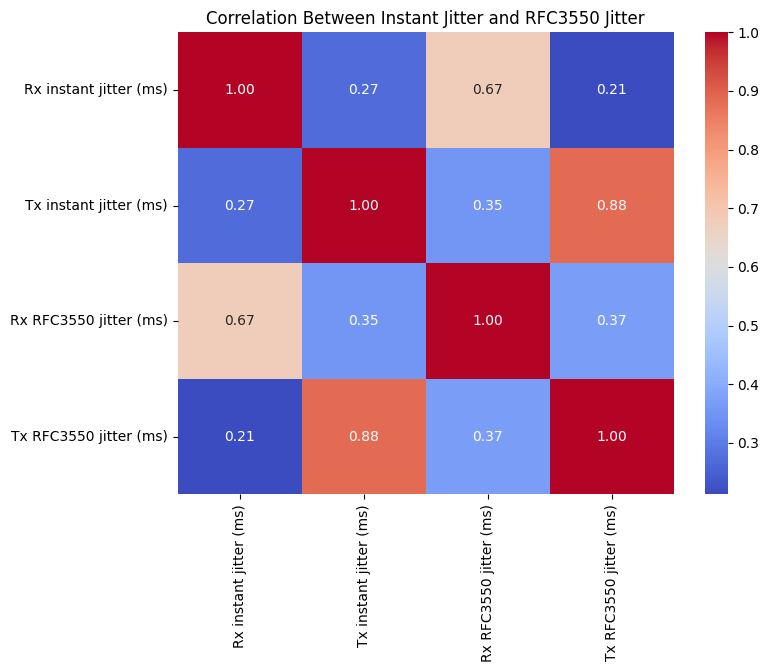

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select jitter columns for correlation analysis
jitter_columns = [
    'Rx instant jitter (ms)', 'Tx instant jitter (ms)', 
    'Rx RFC3550 jitter (ms)', 'Tx RFC3550 jitter (ms)'
]

# Calculate correlation matrix
jitter_correlation = data[jitter_columns].corr()

# Display the correlation matrix
print("Correlation Matrix for Jitter Metrics:")
print(jitter_correlation)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(jitter_correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Instant Jitter and RFC3550 Jitter")
plt.show()


### We can see high values (e.g., 0.8 or above) between:

### * Rx instant jitter (ms) and Rx RFC3550 jitter (ms).
### * Tx instant jitter (ms) and Tx RFC3550 jitter (ms).

### Since instant jitter is more intuitive and directly reflects real-time conditions, keeping it and dropping RFC3550 jitter simplifies the model without losing much information.

## Cleaning & Extracting Necessary Features

### Column selection retained the most relevant features, reducing unnecessary noise in the dataset.

### Columns Dropped:

### 1. Download bandwidth: Redundant, as Download (Rx) bandwidth (bps) provides the same information in numeric format.
### 2. Upload bandwidth:   Redundant, as Upload (Tx) bandwidth (bps) provides the same information in numeric format.

### 3. Rx RFC3550 jitter (ms)
### 4. Tx RFC3550 jitter (ms) 

### The dataset already includes Rx instant jitter (ms) and Tx instant jitter (ms), which capture jitter values for incoming and outgoing packets.The RFC3550 jitter columns represent a standardized method to compute jitter, but in practice, they are often highly correlated with the "instant jitter" columns.

### 5. Rx packet loss burst length (packets)
### 6. Tx packet loss burst length (packets)

### These columns measure the length of consecutive packets lost during download (Rx) or upload (Tx).
### While they provide detailed insights into packet loss events, their impact is already captured by Rx packet loss (percent) and Tx packet loss (percent): For example, if 5 packets are lost consecutively, it would already contribute to the total packet loss percentage.
### We chose Packet Loss Percent over the Number of Packets Dropped because it is normalized, allowing for easy comparison across datasets and services, regardless of the total packet count. Additionally, it is more directly correlated with QoE and easier for machine learning models to interpret and scale.

In [6]:
# Select necessary numeric columns for analysis
columns_to_keep = [
    "Local time", 
    "Download (Rx) bandwidth (bps)", 
    "Upload (Tx) bandwidth (bps)",
    "Rx packet loss (percent)", 
    "Tx packet loss (percent)", 
    "RTT (ping) (ms)",
    "Rx instant jitter (ms)", 
    "Tx instant jitter (ms)"
]

# Subset the dataset
data = data[columns_to_keep]

# Display the cleaned subset
print("Selected Columns:")
display(data.head())

# Check for any missing or invalid values in the selected columns
print("\nMissing Values After Column Selection:")
print(data.isnull().sum())


Selected Columns:


,Local time,Download (Rx) bandwidth (bps),Upload (Tx) bandwidth (bps),Rx packet loss (percent),Tx packet loss (percent),RTT (ping) (ms),Rx instant jitter (ms),Tx instant jitter (ms)
0,22-11-2023 17:29,2180459.5,2095309.0,0.391257,0.015329,76.0,13.937400,41.205400
1,22-11-2023 17:29,2248265.8,2091075.0,0.000008,0.017393,49.0,13.645300,42.226900
2,22-11-2023 17:29,2260864.2,2091325.8,0.000010,0.022528,49.0,11.302199,35.522100
3,22-11-2023 17:29,2241506.5,2093249.1,0.000013,0.028613,61.0,15.900100,43.328598
4,22-11-2023 17:29,2267823.2,2096676.4,0.000016,0.032748,48.0,13.352600,44.489800



Missing Values After Column Selection:
Local time                       0
Download (Rx) bandwidth (bps)    0
Upload (Tx) bandwidth (bps)      0
Rx packet loss (percent)         0
Tx packet loss (percent)         0
RTT (ping) (ms)                  0
Rx instant jitter (ms)           0
Tx instant jitter (ms)           0
dtype: int64


## Mean Jitter & Jitter Difference

###  **Mean Jitter**

* ### QoE is often affected by the overall jitter in the network, not just Rx (receive) or Tx (transmit) jitter individually.
* ### Mean Jitter provides a single value summarizing the average network instability, representing the combined impact of incoming and outgoing jitter.

### **Jitter Difference**

* ### When there’s a significant difference between Rx and Tx jitter, it often indicates imbalanced network conditions (e.g., poor uplink but stable downlink).
* ### A large Jitter Difference value helps pinpoint whether the bottleneck is on the upload (Tx) or download (Rx) side of the network.


In [7]:
data['Mean Jitter'] = (data['Rx instant jitter (ms)'] + data['Tx instant jitter (ms)']) / 2

data['Jitter Difference'] = data['Rx instant jitter (ms)'] - data['Tx instant jitter (ms)']


## Unit Consistency

###  Ensures all numeric metrics are in comparable units. bps (bandwidth) was converted to Mbps for easier interpretation.

In [8]:
# Convert bandwidth metrics from bps to Mbps
data['Download (Rx) bandwidth (Mbps)'] = data['Download (Rx) bandwidth (bps)'] / 1e6
data['Upload (Tx) bandwidth (Mbps)'] = data['Upload (Tx) bandwidth (bps)'] / 1e6

# Drop the original bandwidth columns (in bps) to avoid confusion
data.drop(columns=['Download (Rx) bandwidth (bps)', 'Upload (Tx) bandwidth (bps)'], inplace=True)

# Display the updated dataset
print("\nDataset After Unit Conversion:")
display(data.head())



Dataset After Unit Conversion:


,Local time,Rx packet loss (percent),Tx packet loss (percent),RTT (ping) (ms),Rx instant jitter (ms),Tx instant jitter (ms),Mean Jitter,Jitter Difference,Download (Rx) bandwidth (Mbps),Upload (Tx) bandwidth (Mbps)
0,22-11-2023 17:29,0.391257,0.015329,76.0,13.937400,41.205400,27.571400,-27.268000,2.180459,2.095309
1,22-11-2023 17:29,0.000008,0.017393,49.0,13.645300,42.226900,27.936100,-28.581600,2.248266,2.091075
2,22-11-2023 17:29,0.000010,0.022528,49.0,11.302199,35.522100,23.412150,-24.219901,2.260864,2.091326
3,22-11-2023 17:29,0.000013,0.028613,61.0,15.900100,43.328598,29.614349,-27.428498,2.241506,2.093249
4,22-11-2023 17:29,0.000016,0.032748,48.0,13.352600,44.489800,28.921200,-31.137200,2.267823,2.096676


## Standardizing the Timestamp

### Timestamps in the raw dataset might be in string format, making it difficult to perform time-based calculations or analysis. Standardization converts them to a machine-readable datetime format.

In [9]:
# Convert "Local time" to datetime format
data['Local time'] = pd.to_datetime(data['Local time'], errors='coerce')

# Check for invalid timestamps
print("\nRows with Invalid Timestamps:")
print(data[data['Local time'].isnull()])

# Remove rows with invalid timestamps
data = data.dropna(subset=['Local time'])

# Sort the data by timestamp (if not already sorted)
data = data.sort_values(by='Local time')

# Display the standardized timestamps
print("\nData After Standardizing Timestamps:")
display(data.head())


Rows with Invalid Timestamps:
Empty DataFrame
Columns: [Local time, Rx packet loss (percent), Tx packet loss (percent), RTT (ping) (ms), Rx instant jitter (ms), Tx instant jitter (ms), Mean Jitter, Jitter Difference, Download (Rx) bandwidth (Mbps), Upload (Tx) bandwidth (Mbps)]
Index: []

Data After Standardizing Timestamps:


/tmp/ipykernel_17/1601050059.py:2: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['Local time'] = pd.to_datetime(data['Local time'], errors='coerce')


,Local time,Rx packet loss (percent),Tx packet loss (percent),RTT (ping) (ms),Rx instant jitter (ms),Tx instant jitter (ms),Mean Jitter,Jitter Difference,Download (Rx) bandwidth (Mbps),Upload (Tx) bandwidth (Mbps)
728,2023-11-22 17:15:00,0.000000,0.0,59.00000,18.075400,33.649998,25.862699,-15.574598,1.597503,2.073520
706,2023-11-22 17:15:00,0.057744,0.0,42.00000,14.900800,25.573900,20.237350,-10.673100,1.785374,2.071365
707,2023-11-22 17:15:00,0.000000,0.0,42.00000,15.165999,59.054398,37.110198,-43.888399,1.782008,2.097152
708,2023-11-22 17:15:00,0.000000,0.0,195.62039,62.715897,51.525997,57.120947,11.189900,1.726811,1.990756
709,2023-11-22 17:15:00,0.000000,0.0,115.00000,32.779000,51.525997,42.152499,-18.746997,2.013898,2.074388


## Adding Elapsed Time Feature

### To introduce a temporal dimension, capturing how QoS metrics change over time. Helps identify whether network conditions improve or degrade over time.

In [10]:
# Calculate elapsed time in seconds from the first timestamp
data['Elapsed Time'] = (data['Local time'] - data['Local time'].iloc[0]).dt.total_seconds()

# Display the dataset with the new "Elapsed Time" column
print("\nDataset with Elapsed Time:")
display(data.head(100))


Dataset with Elapsed Time:


,Local time,Rx packet loss (percent),Tx packet loss (percent),RTT (ping) (ms),Rx instant jitter (ms),Tx instant jitter (ms),Mean Jitter,Jitter Difference,Download (Rx) bandwidth (Mbps),Upload (Tx) bandwidth (Mbps),Elapsed Time
728,2023-11-22 17:15:00,0.000000e+00,0.0,59.00000,18.075400,33.649998,25.862699,-15.574598,1.597503,2.073520,0.0
706,2023-11-22 17:15:00,5.774397e-02,0.0,42.00000,14.900800,25.573900,20.237350,-10.673100,1.785374,2.071365,0.0
707,2023-11-22 17:15:00,0.000000e+00,0.0,42.00000,15.165999,59.054398,37.110198,-43.888399,1.782008,2.097152,0.0
708,2023-11-22 17:15:00,0.000000e+00,0.0,195.62039,62.715897,51.525997,57.120947,11.189900,1.726811,1.990756,0.0
709,2023-11-22 17:15:00,0.000000e+00,0.0,115.00000,32.779000,51.525997,42.152499,-18.746997,2.013898,2.074388,0.0
...,...,...,...,...,...,...,...,...,...,...,...
601,2023-11-22 17:17:00,8.230000e-08,0.0,63.00000,14.017699,26.984499,20.501099,-12.966800,2.383072,2.092579,120.0
594,2023-11-22 17:17:00,0.000000e+00,0.0,46.00000,13.104400,23.762700,18.433550,-10.658300,2.456453,2.094249,120.0
599,2023-11-22 17:17:00,1.372995e+00,0.0,53.00000,22.653000,32.599300,27.626150,-9.946300,2.266962,2.097152,120.0
598,2023-11-22 17:17:00,1.107951e+00,0.0,63.00000,11.134399,22.435299,16.784849,-11.300900,2.337873,2.094947,120.0


## Handling Missing & Invalid Data

In [11]:
# Check for missing values in numeric columns
numeric_columns = data.select_dtypes(include=[np.number]).columns
print("\nMissing Values in Numeric Columns Before Imputation:")
print(data[numeric_columns].isnull().sum())

# Impute missing values with the mean of each column
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# Verify missing values are handled
print("\nMissing Values After Imputation:")
print(data[numeric_columns].isnull().sum())



Missing Values in Numeric Columns Before Imputation:
Rx packet loss (percent)          0
Tx packet loss (percent)          0
RTT (ping) (ms)                   0
Rx instant jitter (ms)            0
Tx instant jitter (ms)            0
Mean Jitter                       0
Jitter Difference                 0
Download (Rx) bandwidth (Mbps)    0
Upload (Tx) bandwidth (Mbps)      0
Elapsed Time                      0
dtype: int64

Missing Values After Imputation:
Rx packet loss (percent)          0
Tx packet loss (percent)          0
RTT (ping) (ms)                   0
Rx instant jitter (ms)            0
Tx instant jitter (ms)            0
Mean Jitter                       0
Jitter Difference                 0
Download (Rx) bandwidth (Mbps)    0
Upload (Tx) bandwidth (Mbps)      0
Elapsed Time                      0
dtype: int64


## Outlier Detection & Analysis

### Outlier Detection:


* ### Used z-scores to identify rows with extreme values (absolute z-score > 3) in numeric columns.
* ### Marked these rows as outliers using a binary column (Is Outlier).
* ### Instead of removing outliers, flagged them for separate analysis, as they represent critical rural network conditions.

Number of Outliers Preserved: 70

Summary of Outliers:


,Local time,Rx packet loss (percent),Tx packet loss (percent),RTT (ping) (ms),Rx instant jitter (ms),Tx instant jitter (ms),Mean Jitter,Jitter Difference,Download (Rx) bandwidth (Mbps),Upload (Tx) bandwidth (Mbps),Elapsed Time
count,70,70.000000,7.000000e+01,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,2023-11-22 17:21:53.142857216,0.971732,3.768765e-02,76.439167,30.567184,66.448514,48.507849,-35.881330,1.941360,2.077026,413.142857
min,2023-11-22 17:15:00,0.000000,0.000000e+00,42.000000,7.316100,3.765300,5.540700,-391.736101,0.891312,1.846313,0.000000
25%,2023-11-22 17:19:00,0.000031,0.000000e+00,54.000000,14.060325,31.347300,24.155575,-40.324024,1.817693,2.084503,240.000000
50%,2023-11-22 17:21:30,0.365787,1.759000e-13,63.000000,17.315200,45.312849,34.116174,-20.629049,1.962608,2.091628,390.000000
75%,2023-11-22 17:26:00,2.245641,2.294508e-03,77.750000,23.503325,91.514521,57.896337,-9.446900,2.217237,2.096104,660.000000
max,2023-11-22 17:29:00,3.727192,4.254852e-01,195.620390,126.406494,409.229000,213.360950,53.370200,2.399272,2.097152,840.000000
std,NaN,1.219064,8.876166e-02,38.999636,30.925376,64.411476,38.992560,64.255389,0.350603,0.041862,257.926755



Summary of Non-Outliers:


,Local time,Rx packet loss (percent),Tx packet loss (percent),RTT (ping) (ms),Rx instant jitter (ms),Tx instant jitter (ms),Mean Jitter,Jitter Difference,Download (Rx) bandwidth (Mbps),Upload (Tx) bandwidth (Mbps),Elapsed Time
count,659,659.000000,6.590000e+02,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000
mean,2023-11-22 17:22:08.649468928,0.301367,1.937801e-03,58.603360,16.248879,43.013208,29.631043,-26.764329,2.162935,2.091903,428.649469
min,2023-11-22 17:15:00,0.000000,0.000000e+00,36.000000,0.652100,0.500000,1.944200,-108.972600,1.597503,2.045636,0.000000
25%,2023-11-22 17:18:00,0.000035,0.000000e+00,50.000000,13.310849,29.350450,22.602375,-34.659551,2.077518,2.091348,180.000000
50%,2023-11-22 17:21:00,0.011524,0.000000e+00,57.000000,15.605000,36.149498,26.550149,-20.861800,2.193316,2.094111,360.000000
75%,2023-11-22 17:26:00,0.386542,1.570000e-10,64.000000,18.649450,50.251199,33.758800,-12.401600,2.272177,2.096325,660.000000
max,2023-11-22 17:29:00,2.304205,9.084158e-02,106.000000,45.817497,129.796200,82.183200,29.542701,2.456453,2.097152,840.000000
std,NaN,0.523636,1.016629e-02,12.234197,5.456673,22.160277,11.826627,21.959733,0.160002,0.007542,266.109817


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

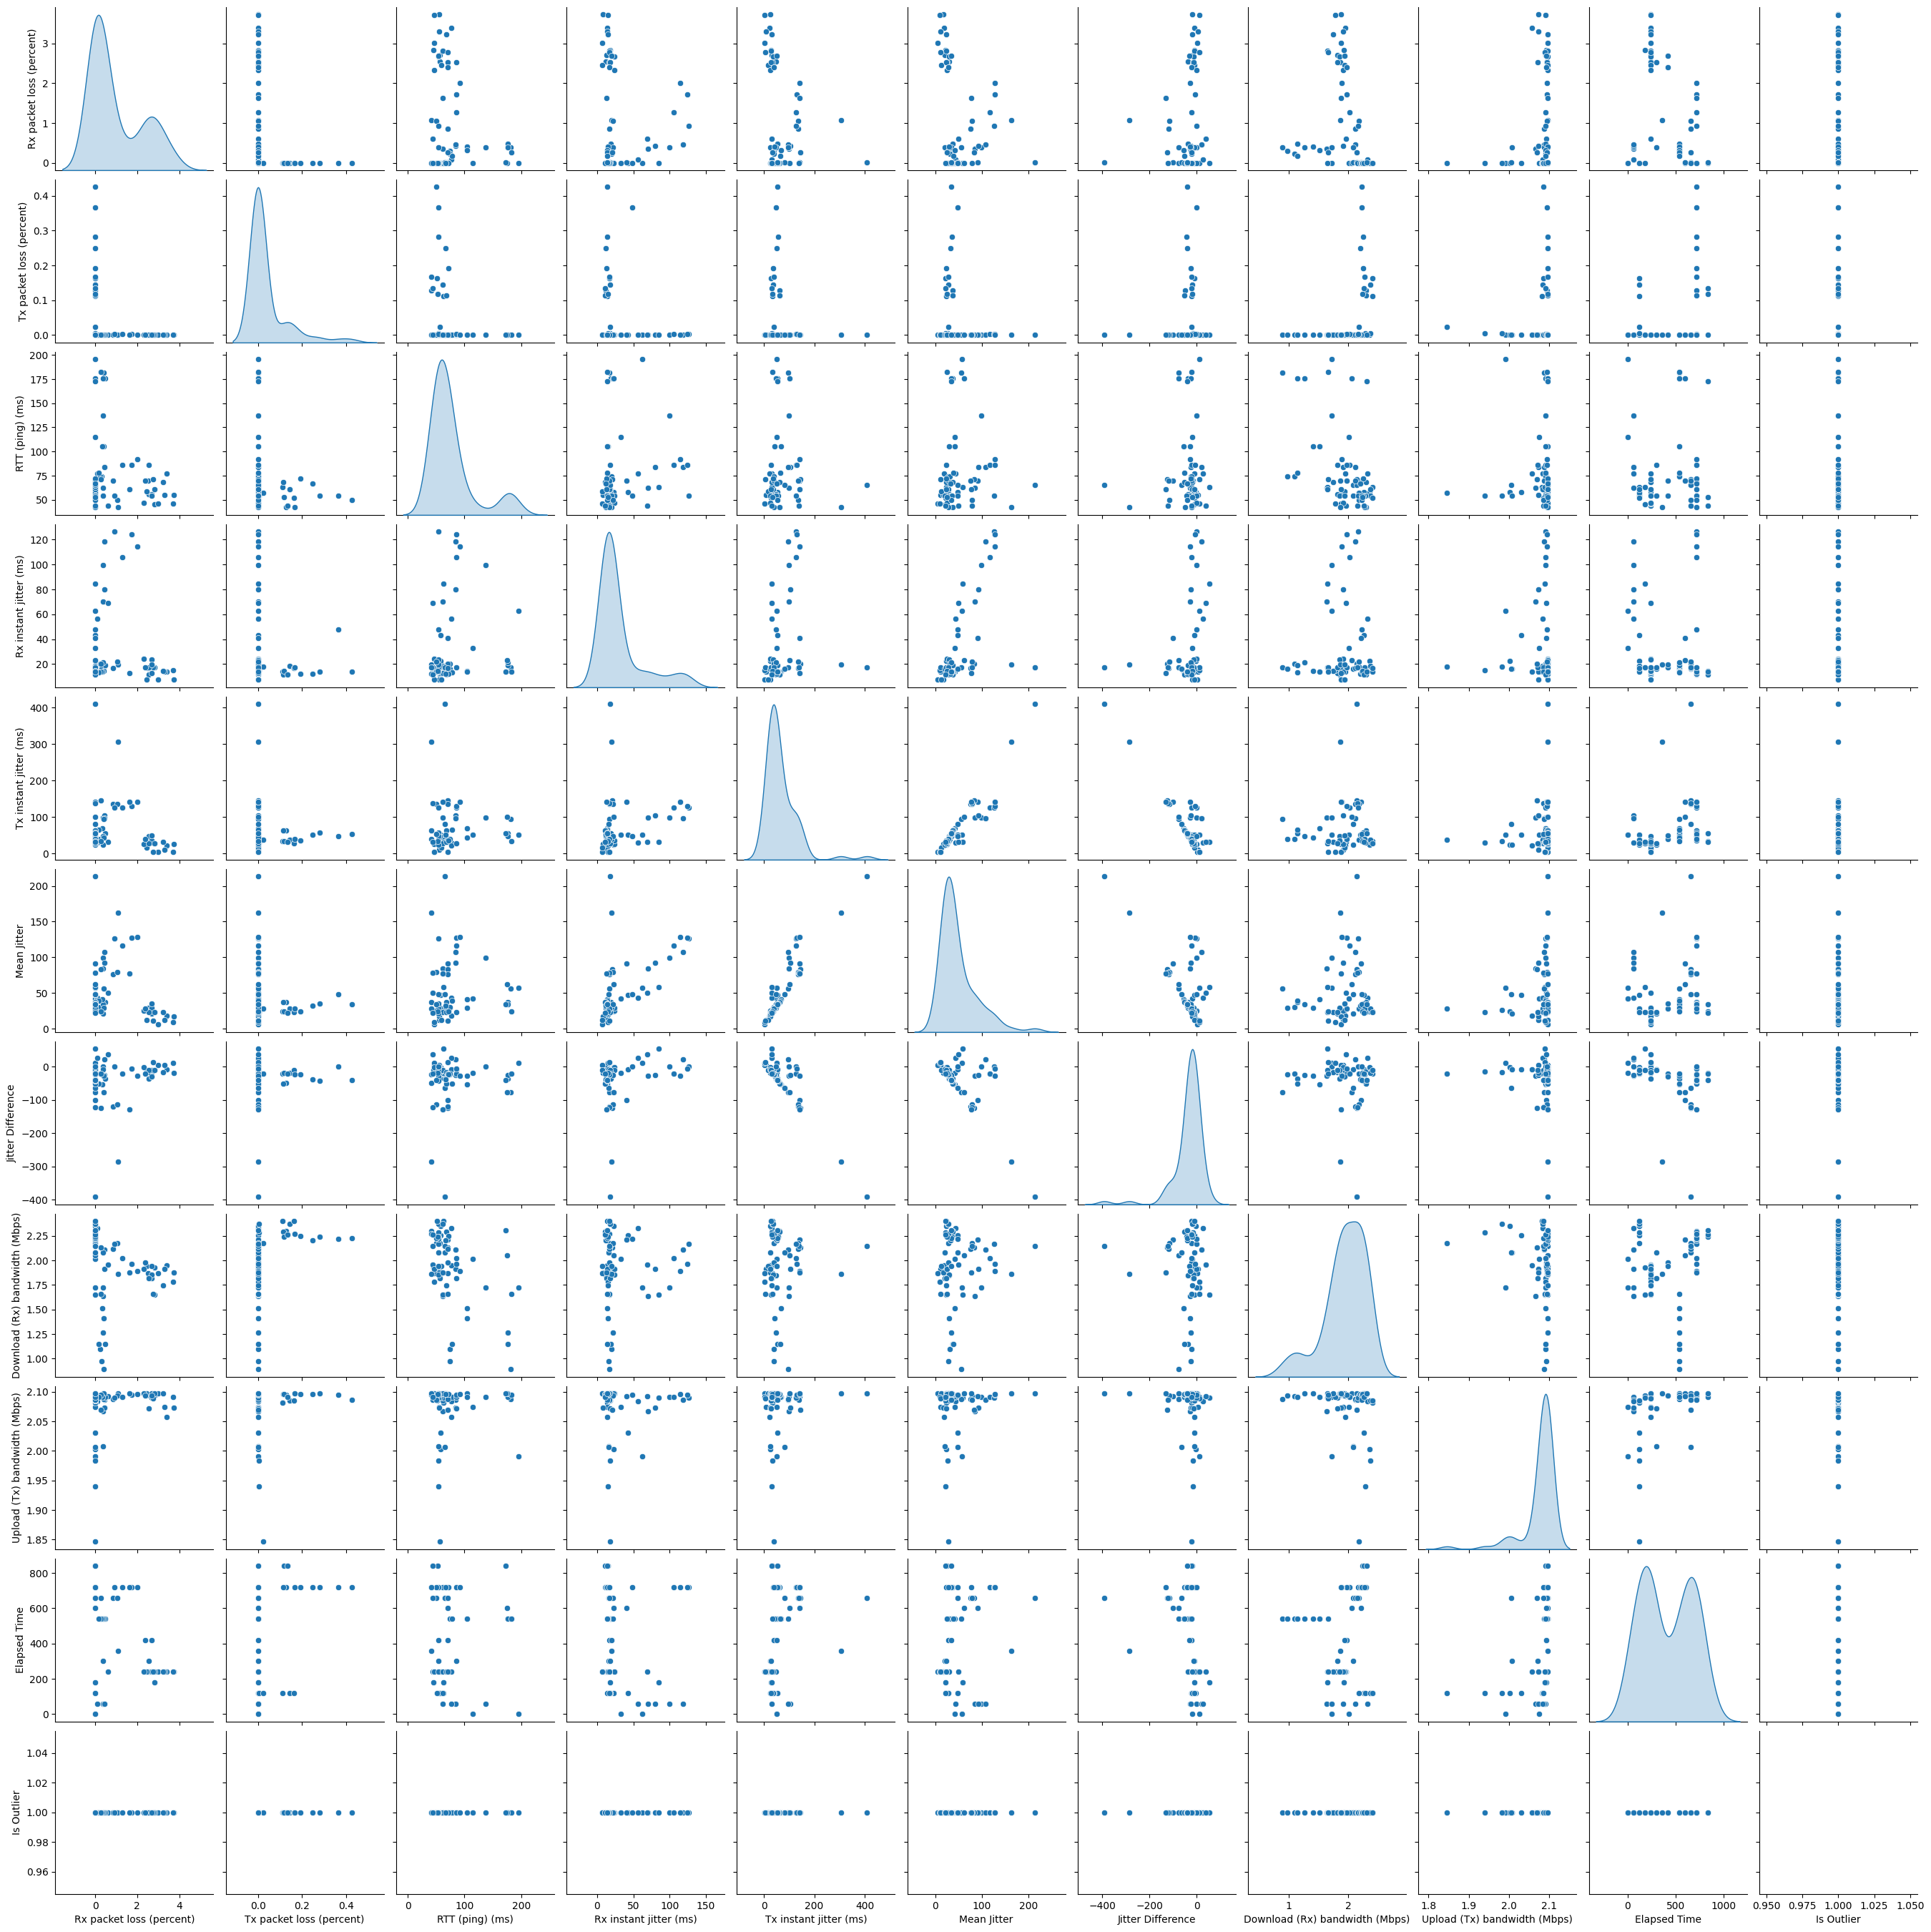

In [12]:
from scipy.stats import zscore
import numpy as np

# Calculate z-scores for numeric columns
numeric_columns = data.select_dtypes(include=[np.number]).columns
z_scores = np.abs(data[numeric_columns].apply(zscore))

# Define a threshold for outliers
threshold = 3

# Flag outliers
data['Is Outlier'] = (z_scores > threshold).any(axis=1)

# Display the number of flagged outliers
num_outliers = data['Is Outlier'].sum()
print(f"Number of Outliers Preserved: {num_outliers}")

# Separate outliers for analysis
outliers = data[data['Is Outlier']]
non_outliers = data[~data['Is Outlier']]

# Summary statistics for outliers vs non-outliers
print("\nSummary of Outliers:")
display(outliers.describe())
print("\nSummary of Non-Outliers:")
display(non_outliers.describe())


# Pairplot for outliers to explore relationships
import seaborn as sns
figplot = sns.pairplot(outliers, diag_kind="kde", markers="o")



### Findings from the Pair Plot:

### * Diagonal Plots (Distributions):Variables like Download Bandwidth showed moderate spread, while jitter and packet loss exhibited higher variability.
### * Scatter Plots: Weak correlations between some variables (e.g., Rx and Tx jitter) suggest that extreme conditions affect QoS metrics independently.
### * Clustering in certain plots indicates distinct types of network degradation.

### **Outliers represent important edge cases (e.g., poor bandwidth, high jitter) that must be retained for analyzing extreme rural conditions.**

## Saving the current prepared data

In [13]:
print("\nDataset after anaylsis & preparation:")
display(data.head(100))

# After handling missing and invalid data
data['Service'] = 'Zoom'


# Save the cleaned and preprocessed data for downstream tasks
output_path = './zoom480p_preprocessed.csv'
data.to_csv(output_path, index=False)

print("\nPreprocessed dataset saved as 'zoom480p_preprocessed.csv'.")



Dataset after anaylsis & preparation:


,Local time,Rx packet loss (percent),Tx packet loss (percent),RTT (ping) (ms),Rx instant jitter (ms),Tx instant jitter (ms),Mean Jitter,Jitter Difference,Download (Rx) bandwidth (Mbps),Upload (Tx) bandwidth (Mbps),Elapsed Time,Is Outlier
728,2023-11-22 17:15:00,0.000000e+00,0.0,59.00000,18.075400,33.649998,25.862699,-15.574598,1.597503,2.073520,0.0,False
706,2023-11-22 17:15:00,5.774397e-02,0.0,42.00000,14.900800,25.573900,20.237350,-10.673100,1.785374,2.071365,0.0,False
707,2023-11-22 17:15:00,0.000000e+00,0.0,42.00000,15.165999,59.054398,37.110198,-43.888399,1.782008,2.097152,0.0,False
708,2023-11-22 17:15:00,0.000000e+00,0.0,195.62039,62.715897,51.525997,57.120947,11.189900,1.726811,1.990756,0.0,True
709,2023-11-22 17:15:00,0.000000e+00,0.0,115.00000,32.779000,51.525997,42.152499,-18.746997,2.013898,2.074388,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
601,2023-11-22 17:17:00,8.230000e-08,0.0,63.00000,14.017699,26.984499,20.501099,-12.966800,2.383072,2.092579,120.0,False
594,2023-11-22 17:17:00,0.000000e+00,0.0,46.00000,13.104400,23.762700,18.433550,-10.658300,2.456453,2.094249,120.0,False
599,2023-11-22 17:17:00,1.372995e+00,0.0,53.00000,22.653000,32.599300,27.626150,-9.946300,2.266962,2.097152,120.0,False
598,2023-11-22 17:17:00,1.107951e+00,0.0,63.00000,11.134399,22.435299,16.784849,-11.300900,2.337873,2.094947,120.0,False



Preprocessed dataset saved as 'zoom480p_preprocessed.csv'.


# 📺 | Services Comparison (Google Meet , Microsoft Teams, Zoom)

## Loading & Inspecting Pre-processed Datasets

In [14]:
# Load preprocessed datasets
gmeet_data = pd.read_csv('/kaggle/input/pre-processed-datasets/gmeet480p_preprocessed.csv')
teams_data = pd.read_csv('/kaggle/input/pre-processed-datasets/teams480p_preprocessed.csv')
zoom_data = pd.read_csv('/kaggle/input/pre-processed-datasets/zoom480p_preprocessed.csv')

# Display dataset info
print("Gmeet Dataset Info:")
print(gmeet_data.info(), "\n")
print("Teams Dataset Info:")
print(teams_data.info(), "\n")
print("Zoom Dataset Info:")
print(zoom_data.info(), "\n")


Gmeet Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667 entries, 0 to 666
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Local time                      667 non-null    object 
 1   Rx packet loss (percent)        667 non-null    float64
 2   Tx packet loss (percent)        667 non-null    float64
 3   RTT (ping) (ms)                 667 non-null    float64
 4   Rx instant jitter (ms)          667 non-null    float64
 5   Tx instant jitter (ms)          667 non-null    float64
 6   Mean Jitter                     667 non-null    float64
 7   Jitter Difference               667 non-null    float64
 8   Download (Rx) bandwidth (Mbps)  667 non-null    float64
 9   Upload (Tx) bandwidth (Mbps)    667 non-null    float64
 10  Elapsed Time                    667 non-null    float64
 11  Is Outlier                      667 non-null    bool   
 12  Service         

## Comparing & Visualizing Key QoS Metrics

### This code is used to compare and visualize the distributions of key QoS metrics.

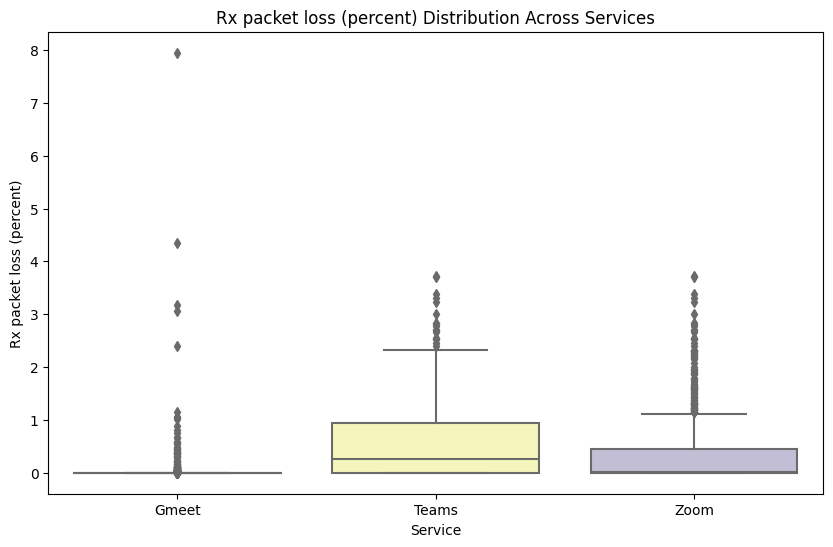

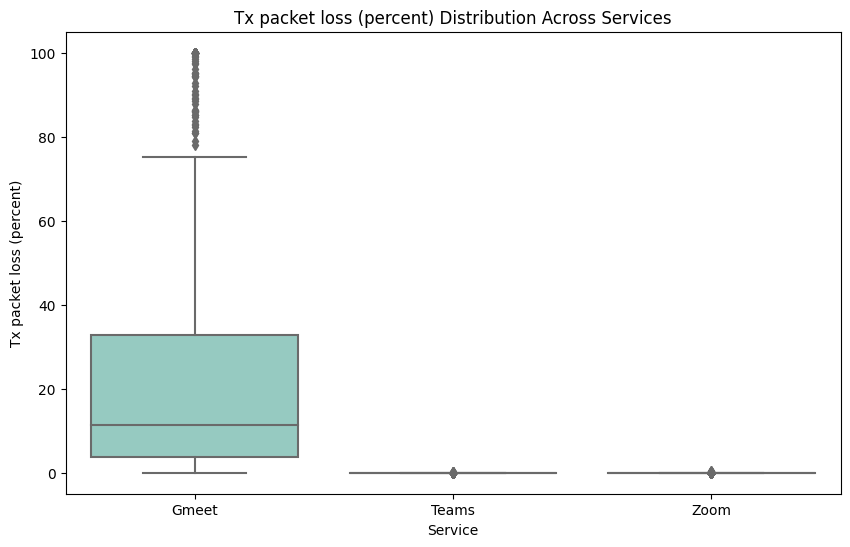

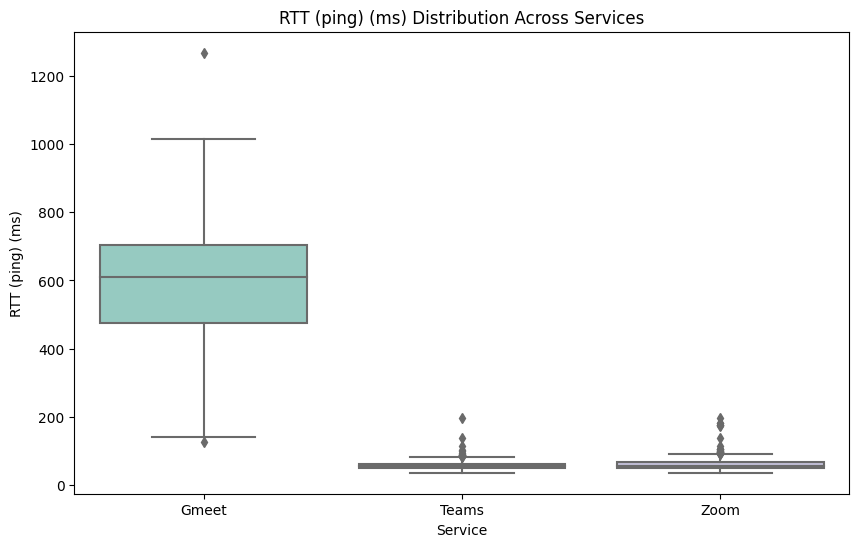

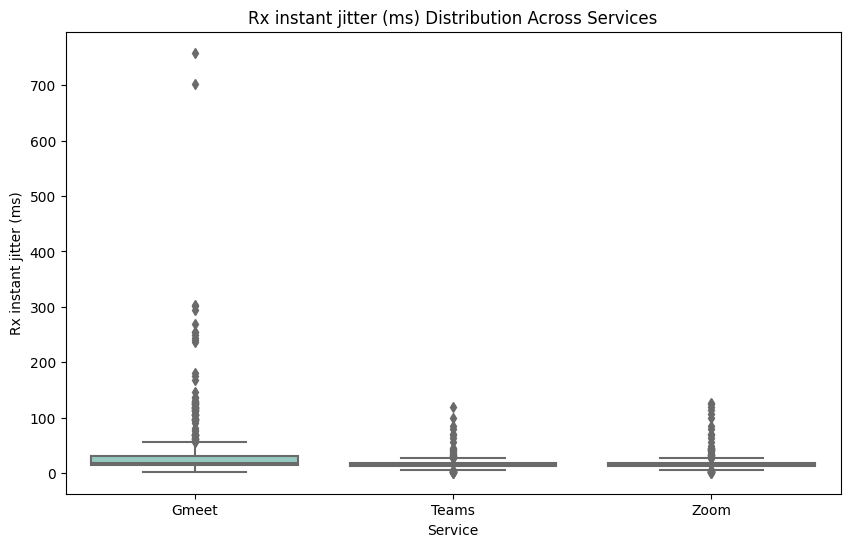

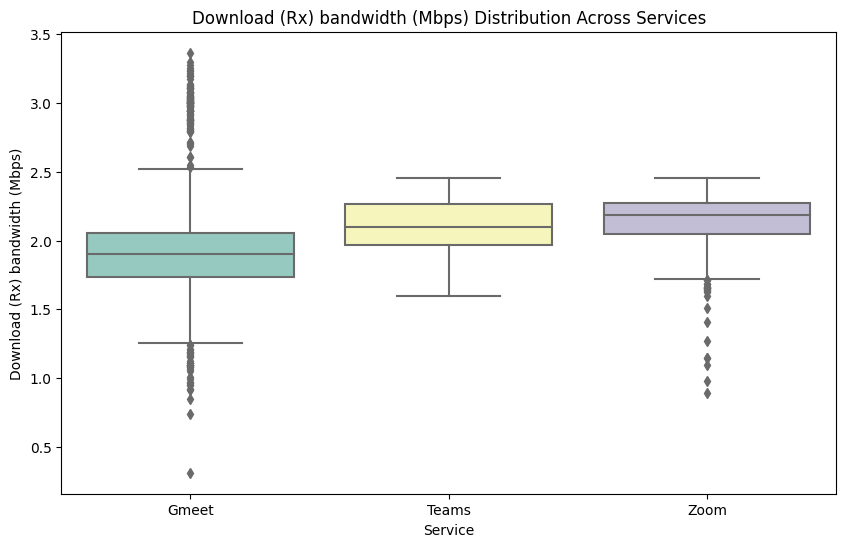

In [15]:
metrics = ['Rx packet loss (percent)', 'Tx packet loss (percent)', 
           'RTT (ping) (ms)', 'Rx instant jitter (ms)', 
           'Download (Rx) bandwidth (Mbps)']

# Visualize each metric for all services
datasets = {'Gmeet': gmeet_data, 'Teams': teams_data, 'Zoom': zoom_data}
for metric in metrics:
    plt.figure(figsize=(10, 6))
    # Combine datasets for the current metric with a 'Service' column
    combined_data = pd.concat([
        data[[metric]].assign(Service=service) for service, data in datasets.items()
    ], ignore_index=True)
    # Create boxplot
    sns.boxplot(data=combined_data, x='Service', y=metric, palette='Set3')
    plt.title(f'{metric} Distribution Across Services')
    plt.ylabel(metric)
    plt.xlabel('Service')
    plt.show()


### From the output:


* ### Gmeet shows consistent performance but with high outliers in RTT and jitter.
* ### Teams demonstrates variability in packet loss and stable bandwidth.
* ### Zoom maintains low outliers and balanced performance across metrics.


## Assessing Variability and Stability

### Variability of the dataset calculated by Standard Deviation.
###  Higher standard deviation indicates more variability in QoS metrics, which could lead to inconsistent QoE.

In [16]:
# Compute standard deviation for QoS metrics
for service, data in datasets.items():
    print(f"Standard Deviation for {service}:")
    display(data[metrics].std())


Standard Deviation for Gmeet:


Rx packet loss (percent)            0.418089
Tx packet loss (percent)           32.228649
RTT (ping) (ms)                   155.069073
Rx instant jitter (ms)             55.286660
Download (Rx) bandwidth (Mbps)      0.486048
dtype: float64

Standard Deviation for Teams:


Rx packet loss (percent)           0.778546
Tx packet loss (percent)           0.014196
RTT (ping) (ms)                   13.858812
Rx instant jitter (ms)            11.091293
Download (Rx) bandwidth (Mbps)     0.198252
dtype: float64

Standard Deviation for Zoom:


Rx packet loss (percent)           0.654023
Tx packet loss (percent)           0.030842
RTT (ping) (ms)                   17.524060
Rx instant jitter (ms)            11.635208
Download (Rx) bandwidth (Mbps)     0.197629
dtype: float64

### 1.  Google Meet


* ### High variability is observed in Tx packet loss (32.22%), RTT (155.07 ms), and Rx instant jitter (55.29 ms), indicating inconsistent performance.
* ### The bandwidth (0.49 Mbps) shows lower variability, suggesting more stable download speeds.\
* ### The high standard deviation in packet loss and RTT indicates QoS inconsistencies affecting user experience.

### 2. Microsoft Teams


* ### Low variability is observed in Tx packet loss (0.01%) and Rx instant jitter (11.09 ms), suggesting consistent performance in these metrics.
* ### RTT (13.85 ms) and Rx packet loss (0.78%) have moderate variability, indicating some instability.
* ### The low standard deviations indicate better overall stability compared to Gmeet and Zoom.

### 3. Zoom:


* ### Moderate variability is observed in Rx packet loss (0.65%), RTT (17.52 ms), and Rx instant jitter (11.65 ms), indicating relatively consistent performance.
* ### Bandwidth variability is low (0.19 Mbps), which helps maintain steady download speeds.
* ### The moderate standard deviations indicate a balance between stability and variability.



### Here, we Identify outliers in QoS metrics using the 1.5 × IQR rule for each service and metric.

### Outliers represent extreme values that deviate significantly from the typical range, potentially indicating extremely poor network performance with respect to our dataset.

In [17]:
# Identify outliers for each metric using 1.5 * IQR rule
for service, data in datasets.items():
    print(f"Outliers for {service}:")
    for metric in metrics:
        q1 = data[metric].quantile(0.25)
        q3 = data[metric].quantile(0.75)
        iqr = q3 - q1
        outliers = data[(data[metric] < (q1 - 1.5 * iqr)) | (data[metric] > (q3 + 1.5 * iqr))]
        print(f"{metric}: {len(outliers)} outliers")


Outliers for Gmeet:
Rx packet loss (percent): 156 outliers
Tx packet loss (percent): 98 outliers
RTT (ping) (ms): 2 outliers
Rx instant jitter (ms): 79 outliers
Download (Rx) bandwidth (Mbps): 130 outliers
Outliers for Teams:
Rx packet loss (percent): 17 outliers
Tx packet loss (percent): 96 outliers
RTT (ping) (ms): 18 outliers
Rx instant jitter (ms): 36 outliers
Download (Rx) bandwidth (Mbps): 0 outliers
Outliers for Zoom:
Rx packet loss (percent): 87 outliers
Tx packet loss (percent): 173 outliers
RTT (ping) (ms): 26 outliers
Rx instant jitter (ms): 50 outliers
Download (Rx) bandwidth (Mbps): 22 outliers



### 1. Gmeet: High outliers in packet loss, jitter, and bandwidth indicate unstable performance under extreme conditions.
### 2. Teams: Few outliers across metrics show consistent performance, with no bandwidth-related outliers.
### 3. Zoom: Significant outliers in Tx packet loss and moderate in jitter and RTT indicate occasional performance degradation.


### Insights
* ### Teams: Low variability and few outliers make it suitable for modeling stable QoE.
* ### Gmeet: High variability and outliers provide insights into extreme QoS cases.
* ### Zoom: Balanced variability and outliers make it a good mix of stable and unstable scenarios.


## Aggregating Performance Scores of Services (Gmeet, Teams, Zoom)

### The scores for each service (Gmeet, Teams, Zoom) were calculated to evaluate their performance based on key QoS metrics.

### Metrics Considered:


* ### Rx packet loss (percent): Measures packet loss during download (lower is better).
* ### Tx packet loss (percent): Measures packet loss during upload (lower is better).
* ### RTT (ping) (ms): Measures network latency (lower is better).### Rx instant jitter (ms): Measures variability in packet arrival times (lower is better).
* ### Download (Rx) bandwidth (Mbps): Measures network capacity (higher is better).


### Score Calculation Steps:


* ### Normalization: QoS metrics were normalized using Min-Max scaling to bring all values to a comparable range (0 to 1).
* ### Inversion: Normalized values were inverted (1 - normalized) so that better QoS values correspond to higher scores.
* ### Weighted Scoring: Scores were calculated using matrix multiplication with predefined weights for each metric.


### Weights were derived based on their relative impact on QoE, as identified in the research paper "Analysis of the Effect of QoS on Video Conferencing QoE".


1. ### Packet Loss (Rx/Tx): Most significant factors affecting QoE due to their direct impact on audio/video quality. Weight = 0.6 (0.3 each).
2. ### RTT (Latency): Affects responsiveness and synchronization during calls. Weight = 0.2.
3. ### Jitter: Causes frame drops and desynchronization. Weight = 0.1.
4. ### Bandwidth: Ensures sufficient capacity for high-quality video but is less critical under stable conditions. Weight = 0.1.


Average Scores by Service:
Gmeet: 0.7907289052851112
Teams: 0.8644900844340273
Zoom: 0.9026994527840719


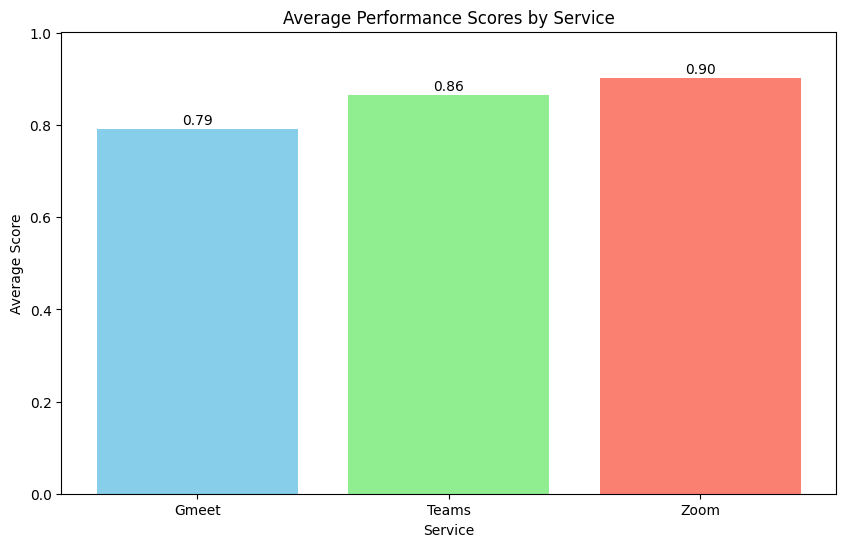

In [18]:
metrics = ['Rx packet loss (percent)', 'Tx packet loss (percent)', 
           'RTT (ping) (ms)', 'Rx instant jitter (ms)', 
           'Download (Rx) bandwidth (Mbps)']

weights = {
    'Rx packet loss (percent)': 0.3,
    'Tx packet loss (percent)': 0.3,
    'RTT (ping) (ms)': 0.2,
    'Rx instant jitter (ms)': 0.1,
    'Download (Rx) bandwidth (Mbps)': 0.1
}

# Function to calculate scores
def calculate_scores(data, metrics, weights):
    # Normalize metrics
    scaler = MinMaxScaler()
    normalized = scaler.fit_transform(data[metrics])
    
    # Invert negative QoS metrics (lower is better)
    inverted = 1 - normalized  # Apply inversion for all metrics
    
    # Correct the inversion for bandwidth (higher is better)
    # Bandwidth is assumed to be the last metric in the list (adjust as necessary)
    inverted[:, metrics.index('Download (Rx) bandwidth (Mbps)')] = normalized[:, metrics.index('Download (Rx) bandwidth (Mbps)')]
    
    # Compute weighted score
    scores = inverted @ pd.Series(weights).values  # Matrix multiplication for scores
    return scores

# Re-run the score calculations with the updated function
gmeet_scores = calculate_scores(gmeet_data, metrics, weights)
teams_scores = calculate_scores(teams_data, metrics, weights)
zoom_scores = calculate_scores(zoom_data, metrics, weights)

# Add scores back to the datasets for analysis
gmeet_data['Score'] = gmeet_scores
teams_data['Score'] = teams_scores
zoom_data['Score'] = zoom_scores

# Calculate average scores for each service
average_scores = {
    'Gmeet': gmeet_data['Score'].mean(),
    'Teams': teams_data['Score'].mean(),
    'Zoom': zoom_data['Score'].mean()
}

print("Average Scores by Service:")
for service, score in average_scores.items():
    print(f"{service}: {score}")

# Plot average scores for each service
plt.figure(figsize=(10, 6))
plt.bar(average_scores.keys(), average_scores.values(), color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Average Performance Scores by Service')
plt.ylabel('Average Score')
plt.xlabel('Service')
plt.ylim(0, max(average_scores.values()) + 0.1)  # Set y-limit slightly above the max score for better visualization
for i, score in enumerate(average_scores.values()):
    plt.text(i, score + 0.01, f"{score:.2f}", ha='center', fontsize=10)  # Add score labels on the bars
plt.show()



### The bar chart shows the average performance scores for Gmeet, Teams, and Zoom, highlighting Zoom as the best-performing service with a score of 0.90, followed by Teams (0.86) and Gmeet (0.79). This ranking reflects the combined weighted impact of key QoS metrics.

## Evaluating Dataset Suitability

### Dataset Diversity

### The code computes the diversity of QoS metrics (e.g., packet loss, RTT, jitter, bandwidth) for each service by calculating the range (difference between maximum and minimum values) of each metric.


* ### For each service, the diversity for each QoS metric is computed as: **Diversity = Max Value − Min Value**
* ### A larger range indicates greater diversity in the dataset for that metric.


### A dataset with higher diversity captures a broader range of network conditions, making it better suited for training a machine learning model that can generalize well. Low diversity may lead to models that overfit specific conditions and perform poorly in real-world scenarios.

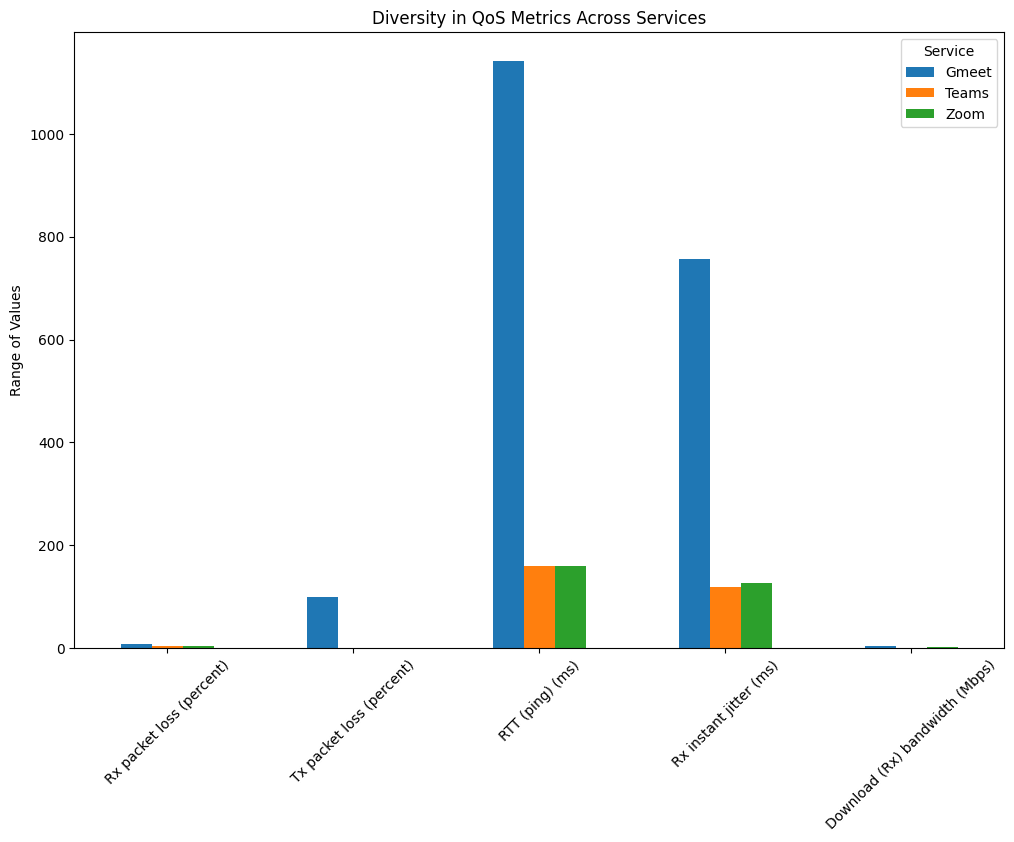

In [19]:
# Calculate diversity in QoS metrics for each service using range
diversity_data = {}
for service, data in datasets.items():
    diversity = data[metrics].max() - data[metrics].min()
    diversity_data[service] = diversity

# Convert to DataFrame for visualization
diversity_df = pd.DataFrame(diversity_data)

# Plot diversity for each metric
diversity_df.plot(kind='bar', figsize=(12, 8), title='Diversity in QoS Metrics Across Services')
plt.ylabel('Range of Values')
plt.xticks(rotation=45)
plt.legend(title="Service", loc='upper right')
plt.show()


###  Gmeet has the highest variability in critical metrics like RTT and Rx jitter. This indicates Gmeet’s dataset covers a broader range of conditions, making it valuable for training robust models that can generalize well.

### Dataset Size

### Analyzing the Dataset Size Across the 3 Services

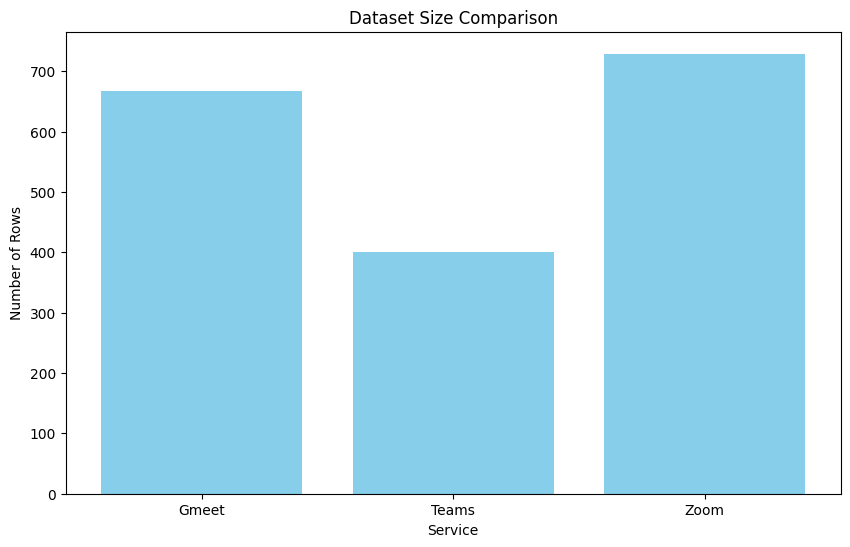

In [20]:
# Calculate dataset size for each service
dataset_sizes = {service: len(data) for service, data in datasets.items()}

# Plot dataset sizes
plt.figure(figsize=(10, 6))
plt.bar(dataset_sizes.keys(), dataset_sizes.values(), color='skyblue')
plt.title('Dataset Size Comparison')
plt.ylabel('Number of Rows')
plt.xlabel('Service')
plt.show()


### The bar chart compares dataset sizes, showing Zoom with the largest number of rows, followed by Gmeet, and then Teams. Larger dataset sizes, like Zoom's, ensure better model training and generalization by providing more data points for learning patterns.

### Distribution of Challenging/Poor QoS Conditons

### Thresholds Defined: Specific thresholds were established for key QoS metrics, such as jitter > 30 ms, packet loss > 1%, and RTT > 150 ms, based on the research paper "Analysis of the Effect of QoS on Video Conferencing QoE" 


### 1. For each metric and service, rows where the metric exceeds the threshold were identified and counted.
### 2. The count of challenging rows was divided by the total number of rows in the dataset, expressed as a percentage.




* ### This analysis helps determine which dataset contains a higher proportion of challenging conditions, making it more suitable for training models to handle poor network scenarios.
* ### Training models on datasets with a higher proportion of challenging conditions can improve their robustness and performance in real-world applications where such conditions are common.


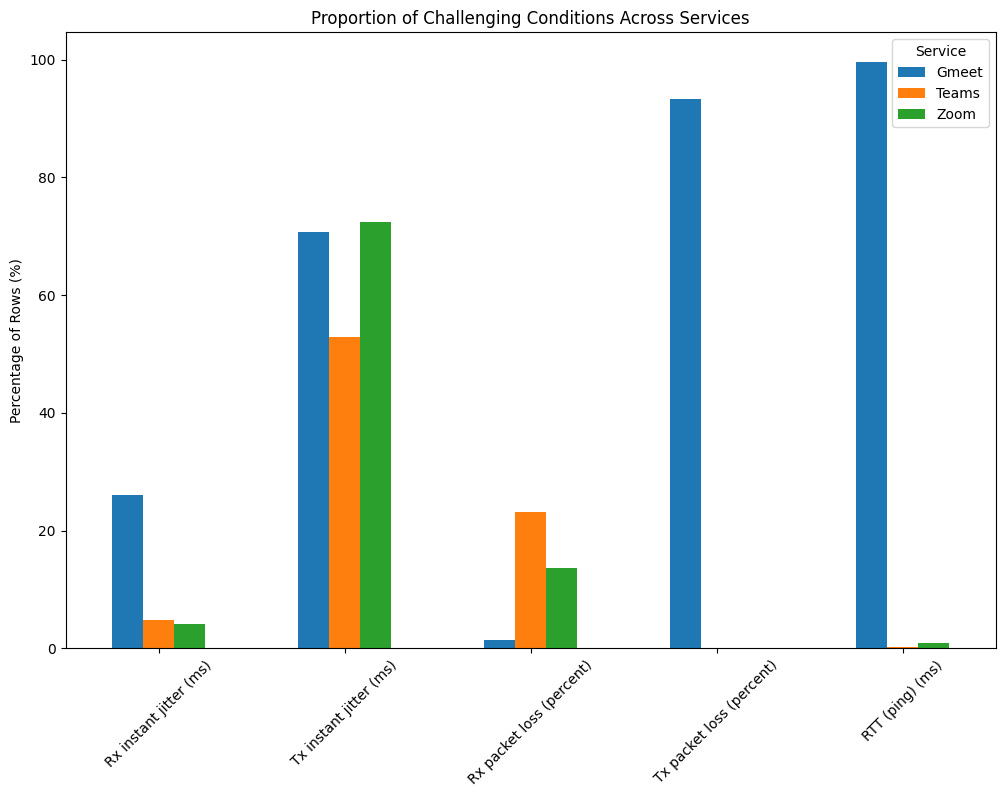

In [21]:
# Define thresholds for challenging conditions
thresholds = {
    'Rx instant jitter (ms)': 30,
    'Tx instant jitter (ms)': 30,
    'Rx packet loss (percent)': 1,
    'Tx packet loss (percent)': 1,
    'RTT (ping) (ms)': 150
}

# Calculate proportion of challenging conditions
challenging_data = {}
for service, data in datasets.items():
    proportions = {}
    for metric, threshold in thresholds.items():
        challenging_rows = len(data[data[metric] > threshold])
        proportions[metric] = challenging_rows / len(data) * 100  # Percentage
    challenging_data[service] = proportions

# Convert to DataFrame for visualization
challenging_df = pd.DataFrame(challenging_data)

# Plot challenging conditions for each metric
challenging_df.plot(kind='bar', figsize=(12, 8), title='Proportion of Challenging Conditions Across Services')
plt.ylabel('Percentage of Rows (%)')
plt.xticks(rotation=45)
plt.legend(title="Service", loc='upper right')
plt.show()



* ### Gmeet has the highest proportion of rows exceeding thresholds for Rx instant jitter, Tx instant jitter, and RTT, indicating frequent poor performance in these metrics.
* ### Zoom exhibits significant challenging conditions in Tx instant jitter but performs better in packet loss metrics compared to Gmeet.
* ### Teams shows the lowest proportion of challenging conditions across most metrics, particularly in jitter and packet loss, highlighting its stability under adverse conditions.


### Gmeet's dataset captures more challenging scenarios, making it valuable for training models to handle poor network conditions.


## Visualizing Dataset Suitability

### Here, we evaluate the overall suitability of the datasets (Gmeet, Teams, Zoom) for machine learning model training by combining three key factors: diversity, size, and challenging conditions.


### 1. Data Normalization: Z-Score Normalization is applied to ensure that all components are on the same scale, avoiding bias due to differing ranges in raw values.

* #### The raw values of the criteria (Diversity, Size, and Challenging Conditions) have different ranges and units.
* #### Z-Score Normalization standardizes these values by centering them around a mean of 0 with a standard deviation of 1, making them directly comparable.
* #### Min-Max normalization scales values between 0 and 1, but it is sensitive to outliers. If one dataset has extreme values in one criterion (e.g., high Diversity), it could dominate the normalized scores, skewing the final rankings.

### 2. Weights are assigned to each criterion:
   * * #### Diversity (50%): Captures network variability for better model generalization.
   * * #### Size (40%): Ensures sufficient data for robust training.
   * * #### Challenging Conditions (10%): Focuses on poor QoS scenarios for model robustness.
### 3.  A weighted final score is calculated for each dataset.


### Datasets are ranked based on their final weighted scores, with the highest-scoring dataset being the most suitable for further analysis & training 


Dataset Suitability Rankings (Weighted - Z-Score):


,Diversity,Size,Challenging Conditions,Final Score
Gmeet,1.414199,0.477942,1.412911,1.039568
Zoom,-0.701604,0.913712,-0.653911,-0.050708
Teams,-0.712595,-1.391654,-0.759001,-0.988859


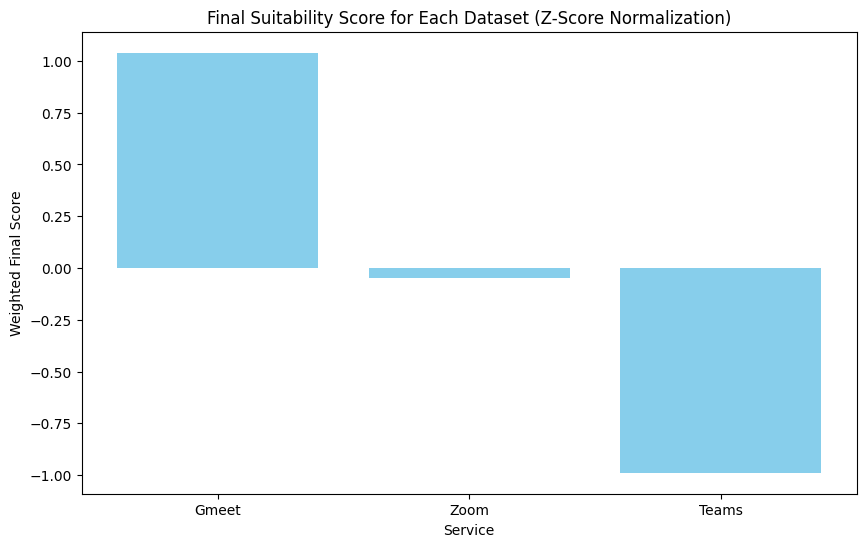

In [22]:
# Define the components of suitability
suitability_ranking = {
    'Diversity': diversity_df.mean(axis=0),  # Average diversity across all metrics
    'Size': pd.Series(dataset_sizes),       # Dataset size
    'Challenging Conditions': challenging_df.mean(axis=0)  # Average % of challenging conditions
}

# Combine into a DataFrame
suitability_df = pd.DataFrame(suitability_ranking)

# Ensure no missing values
suitability_df = suitability_df.fillna(0)

# Apply Z-Score Normalization
scaler = StandardScaler()
zscore_normalized_suitability = scaler.fit_transform(suitability_df)
suitability_df_normalized = pd.DataFrame(zscore_normalized_suitability, columns=suitability_df.columns, index=suitability_df.index)

# Define weights for each criterion
criteria_weights = {
    'Diversity': 0.5,
    'Size': 0.4,
    'Challenging Conditions': 0.1
}

# Calculate weighted final scores
suitability_df_normalized['Final Score'] = (
    suitability_df_normalized['Diversity'] * criteria_weights['Diversity'] +
    suitability_df_normalized['Size'] * criteria_weights['Size'] +
    suitability_df_normalized['Challenging Conditions'] * criteria_weights['Challenging Conditions']
)

# Sort by final score to determine the best dataset
suitability_df_normalized = suitability_df_normalized.sort_values('Final Score', ascending=False)

# Display rankings
print("Dataset Suitability Rankings (Weighted - Z-Score):")
display(suitability_df_normalized)

# Plot final scores
plt.figure(figsize=(10, 6))
plt.bar(suitability_df_normalized.index, suitability_df_normalized['Final Score'], color='skyblue')
plt.title('Final Suitability Score for Each Dataset (Z-Score Normalization)')
plt.ylabel('Weighted Final Score')
plt.xlabel('Service')
plt.show()


### Gmeet has the highest final score (1.04), indicating it is the most suitable dataset for model training & further analysis due to its high diversity and significant coverage of challenging conditions.
### Teams has the lowest score (-0.99), primarily due to its small dataset size and low diversity.

# 📈| Exploratory Data Analysis (EDA)(Google Meet)

## Inspecting the Dataset

In [23]:
# Load the dataset
gmeet_data = pd.read_csv('/kaggle/input/pre-processed-datasets/gmeet480p_preprocessed.csv')

# Display basic information and statistics
print("Dataset Info:")
gmeet_data.info()

print("\nBasic Statistics:")
display(gmeet_data.describe())

# Check for missing values
print("\nMissing Values:")
display(gmeet_data.isnull().sum())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667 entries, 0 to 666
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Local time                      667 non-null    object 
 1   Rx packet loss (percent)        667 non-null    float64
 2   Tx packet loss (percent)        667 non-null    float64
 3   RTT (ping) (ms)                 667 non-null    float64
 4   Rx instant jitter (ms)          667 non-null    float64
 5   Tx instant jitter (ms)          667 non-null    float64
 6   Mean Jitter                     667 non-null    float64
 7   Jitter Difference               667 non-null    float64
 8   Download (Rx) bandwidth (Mbps)  667 non-null    float64
 9   Upload (Tx) bandwidth (Mbps)    667 non-null    float64
 10  Elapsed Time                    667 non-null    float64
 11  Is Outlier                      667 non-null    bool   
 12  Service               

,Rx packet loss (percent),Tx packet loss (percent),RTT (ping) (ms),Rx instant jitter (ms),Tx instant jitter (ms),Mean Jitter,Jitter Difference,Download (Rx) bandwidth (Mbps),Upload (Tx) bandwidth (Mbps),Elapsed Time
count,6.670000e+02,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000
mean,6.371579e-02,26.018947,576.563619,34.676753,69.003597,51.840175,-34.326844,1.972443,0.782972,3117.301349
std,4.180887e-01,32.228649,155.069073,55.286660,52.597740,38.046297,76.525754,0.486048,0.500843,1700.525595
min,0.000000e+00,0.000000,127.051700,1.431200,7.196000,8.177800,-420.823280,0.312022,0.009847,0.000000
25%,0.000000e+00,3.813738,475.252150,14.763000,27.610799,25.683800,-70.469500,1.733680,0.330090,1680.000000
50%,7.350000e-09,11.339743,610.726300,18.460600,60.232500,44.968650,-33.410799,1.904455,0.729086,3240.000000
75%,1.475915e-04,32.683359,703.405550,31.074499,95.001850,65.749449,-5.885750,2.051452,1.172990,4560.000000
max,7.949205e+00,100.000000,1268.022300,758.614400,453.292880,453.365800,676.054560,3.365630,2.079592,5880.000000



Missing Values:


Local time                        0
Rx packet loss (percent)          0
Tx packet loss (percent)          0
RTT (ping) (ms)                   0
Rx instant jitter (ms)            0
Tx instant jitter (ms)            0
Mean Jitter                       0
Jitter Difference                 0
Download (Rx) bandwidth (Mbps)    0
Upload (Tx) bandwidth (Mbps)      0
Elapsed Time                      0
Is Outlier                        0
Service                           0
dtype: int64

## Visualizing Feature Distributions

### Histograms and Kernel Density Plots

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


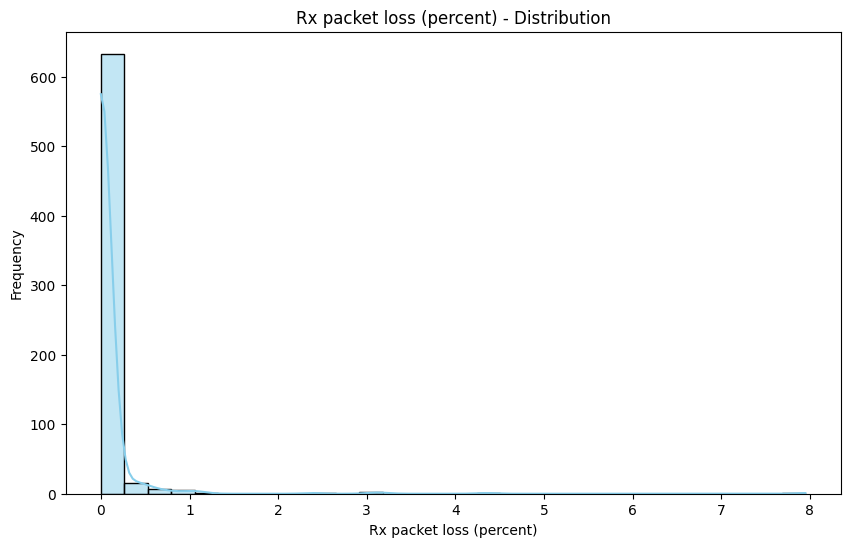

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


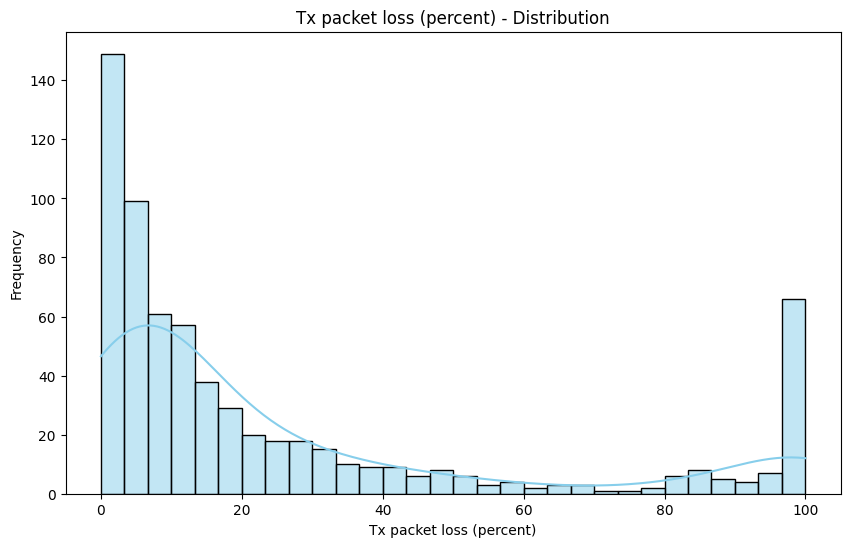

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


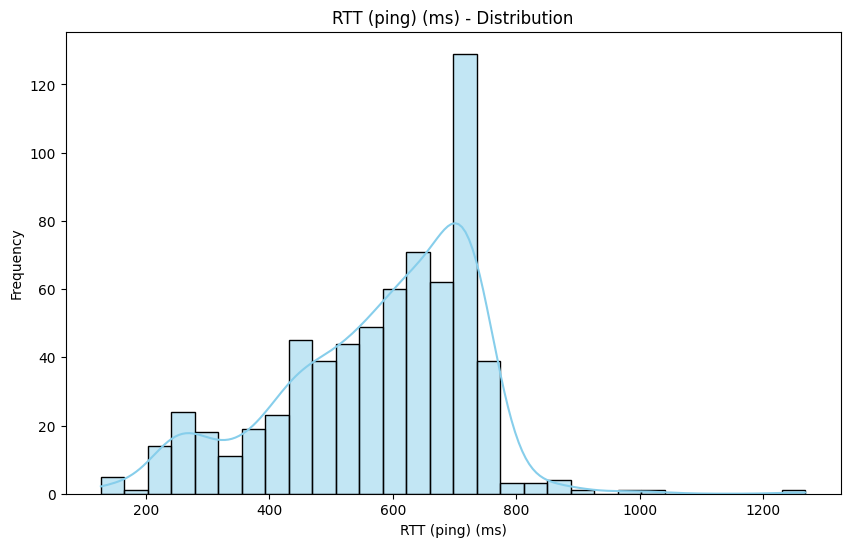

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


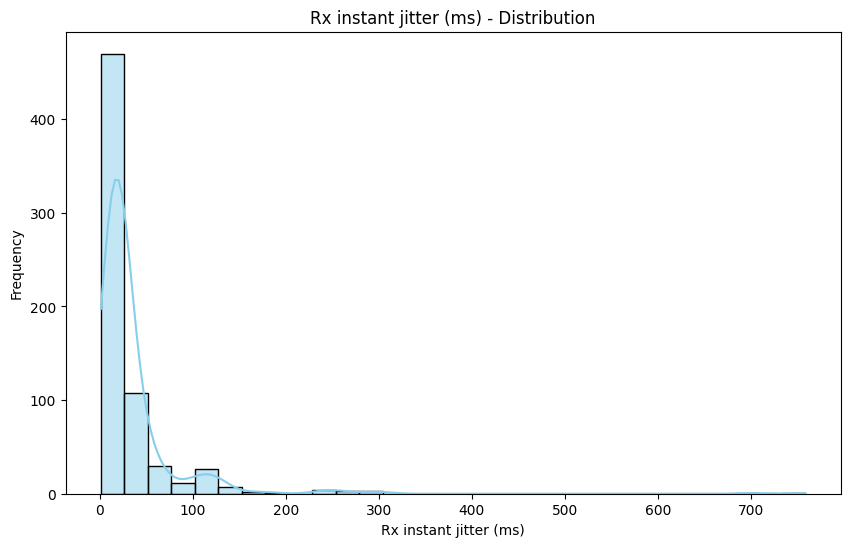

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


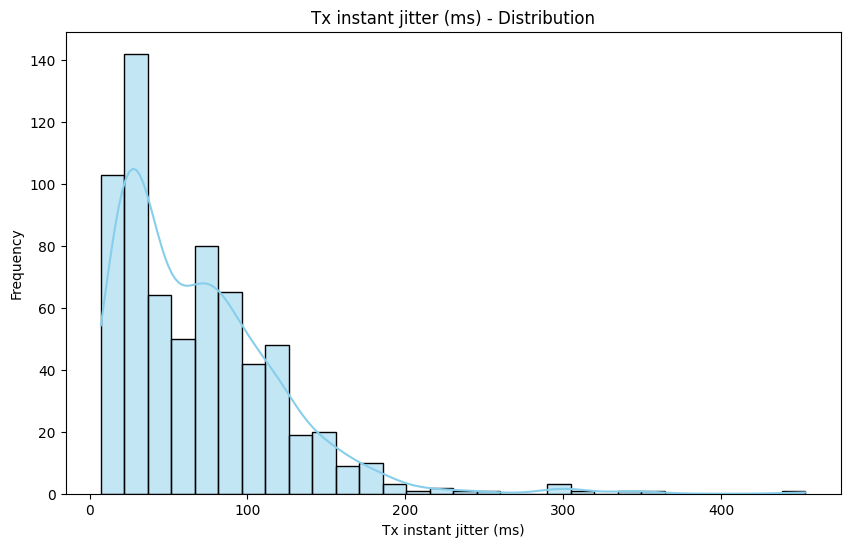

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


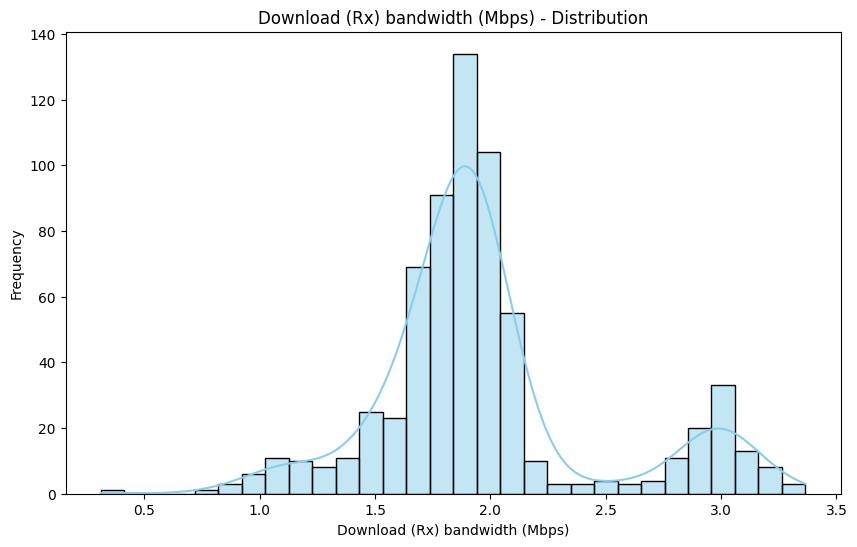

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


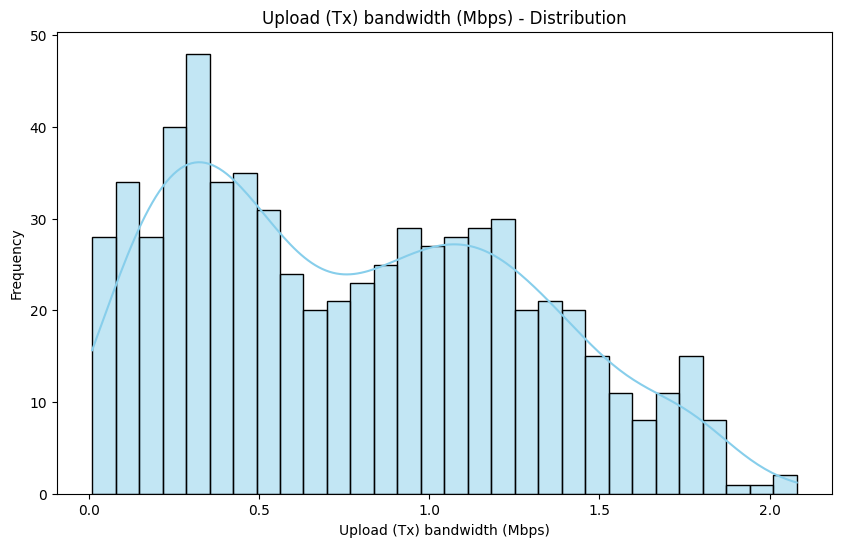

In [24]:
# Plot histograms and KDE for QoS metrics
metrics = ['Rx packet loss (percent)', 'Tx packet loss (percent)', 
           'RTT (ping) (ms)', 'Rx instant jitter (ms)', 'Tx instant jitter (ms)', 
           'Download (Rx) bandwidth (Mbps)', 'Upload (Tx) bandwidth (Mbps)']

for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.histplot(gmeet_data[metric], kde=True, bins=30, color='skyblue')
    plt.title(f'{metric} - Distribution')
    plt.xlabel(metric)
    plt.ylabel('Frequency')
    plt.show()




### Key Points

### Upload (Tx) reliability is less stable than Download (Rx) , with frequent instances of higher packet loss.
### Similiarly, Tx instant jitter & Upload (Tx) Bandwidth is more unstable & spread compared to its Rx counterparts.
### This is in line with the notion of Tx conditions to be considered important in optimizing network conditions compared to the Rx. 

### Distributions of Mean Jitter & Jitter Difference

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


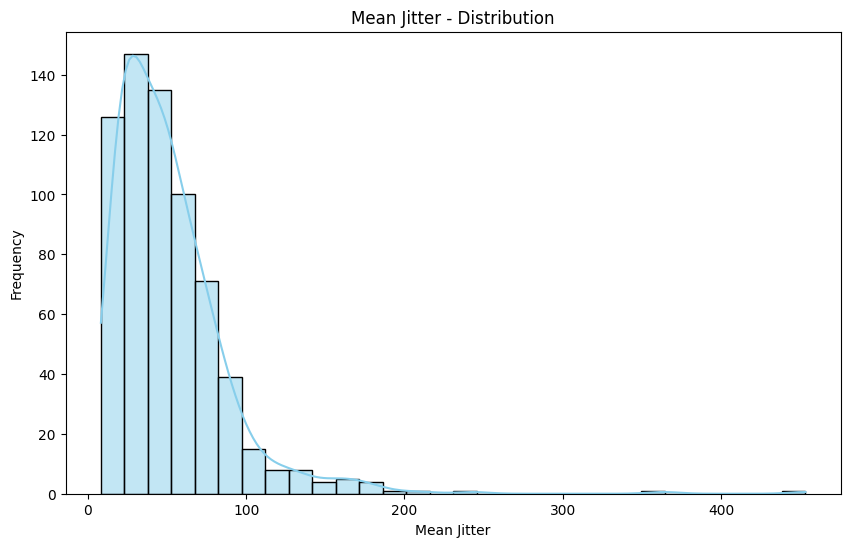

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


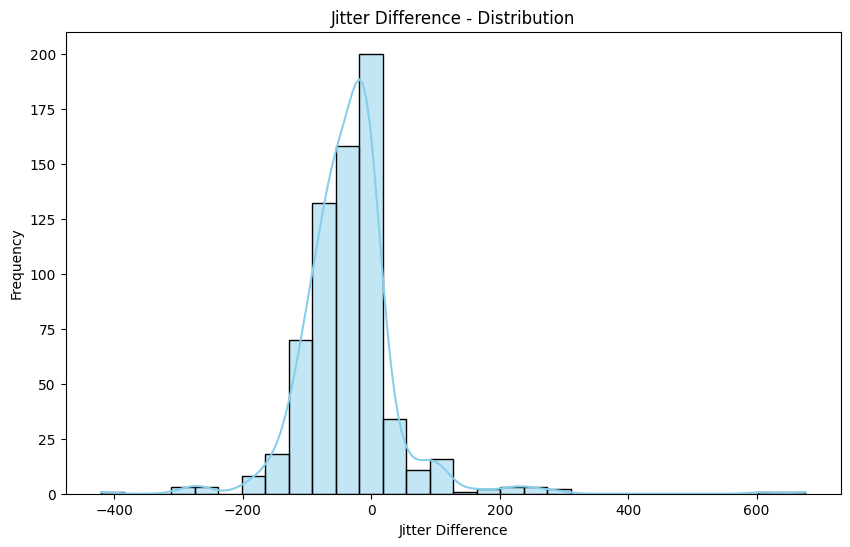

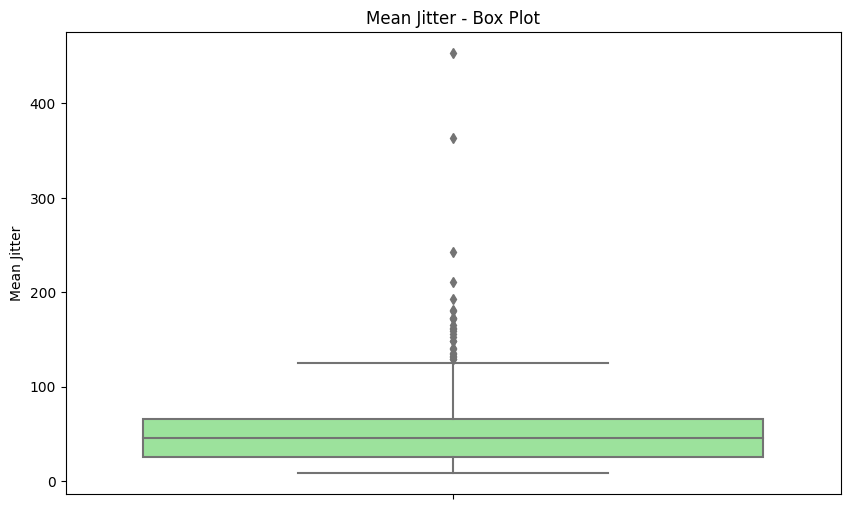

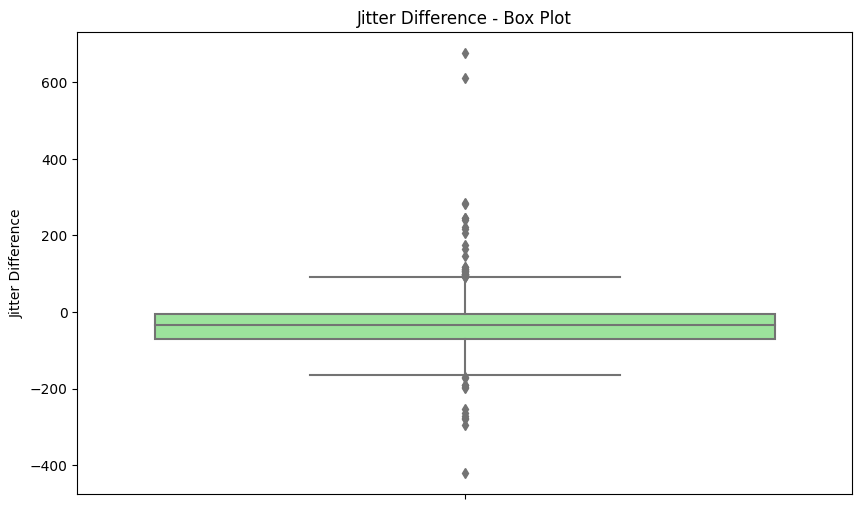

In [25]:
# Visualize distributions of mean jitter and jitter difference
jitter_metrics = ['Mean Jitter', 'Jitter Difference']

for metric in jitter_metrics:
    plt.figure(figsize=(10, 6))
    sns.histplot(gmeet_data[metric], kde=True, bins=30, color='skyblue')
    plt.title(f'{metric} - Distribution')
    plt.xlabel(metric)
    plt.ylabel('Frequency')
    plt.show()

# Box plots
for metric in jitter_metrics:
    plt.figure(figsize=(10, 6))
    sns.boxplot(y=gmeet_data[metric], color='lightgreen')
    plt.title(f'{metric} - Box Plot')
    plt.ylabel(metric)
    plt.show()



* ### ITU-T Recommendation G.1010 specifies that jitter values exceeding 30 ms can cause noticeable quality degradation, with values above 50 ms considered poor for video conferencing.
* ### The histogram and box plots indicate that majority of the mean jitter values lie outside the acceptable values.
* ### Jitter Difference is calculated as Rx instant jitter - Tx instant jitter. Negative values indicate the transmission (Tx) side faces more jitter, while positive values show higher jitter on the reception (Rx) side.
* ### Significant negative values suggest the bottleneck is on the Tx side.


## Correlation Analysis

### Here, we calculate the correlation matrix for the QoS metrics in the dataset, which measures the linear relationship between each pair of metrics. Values range from -1 (strong negative correlation) to +1 (strong positive correlation).

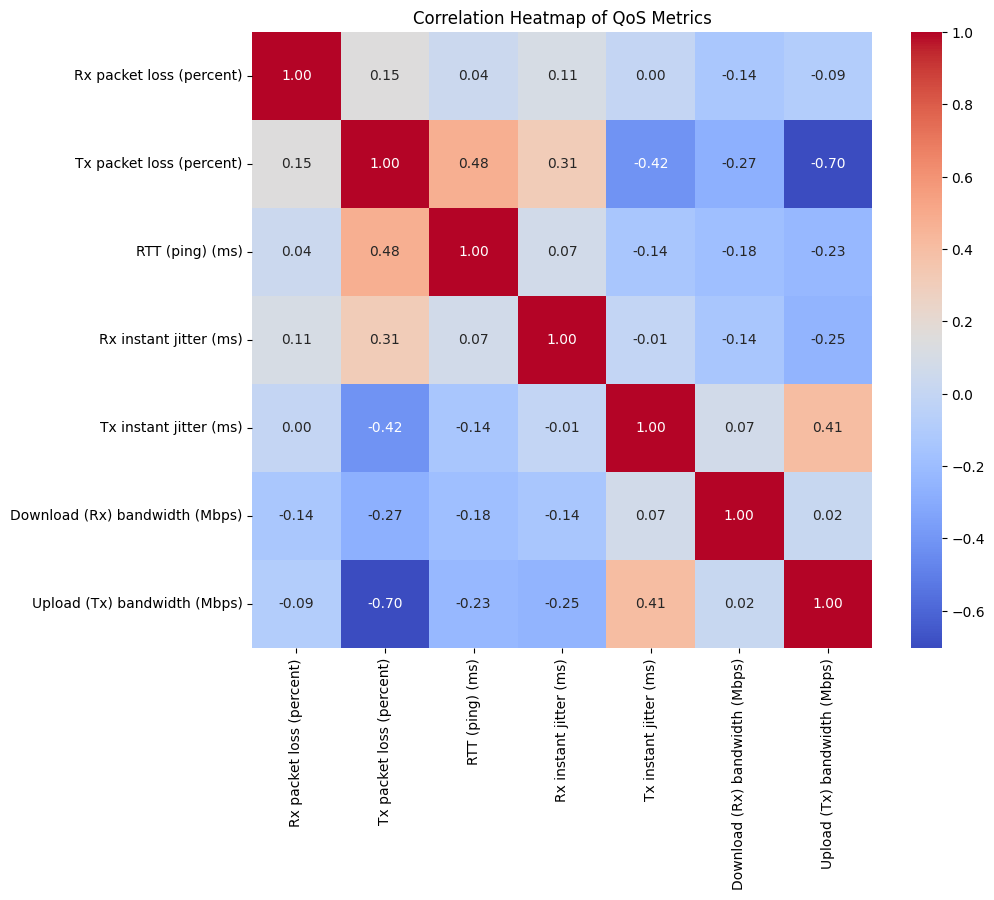

In [26]:
# Calculate correlation matrix
correlation_matrix = gmeet_data[metrics].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of QoS Metrics')
plt.show()



* ### Between Tx Packet Loss and Upload Bandwidth, a strong negative correlation (-0.70) exists, indicating that as upload bandwidth decreases, the percentage of Tx packet loss increases. This suggests poor upload bandwidth significantly affects transmission quality.
* ###  Rx instant jitter and Tx instant jitter do not strongly correlate with other metrics (close to 0), showing they may independently contribute to QoE issues.
* ### The correlation between RTT and Tx Packet Loss is moderate (0.48). This suggests that as transmission packet loss increases, network latency (RTT) also tends to increase.
* ### The correlation between Tx Instant Jitter and Upload Bandwidth is mild (0.41). This implies that unstable or lower upload bandwidth contributes to higher jitter, impacting the smooth delivery of video and audio during conferencing.


## Time-Series Trends

### Bandwidth over Time

### Here, we plot the download bandwidth (Download (Rx) bandwidth) over time, visualizing how bandwidth varies throughout the captured session.

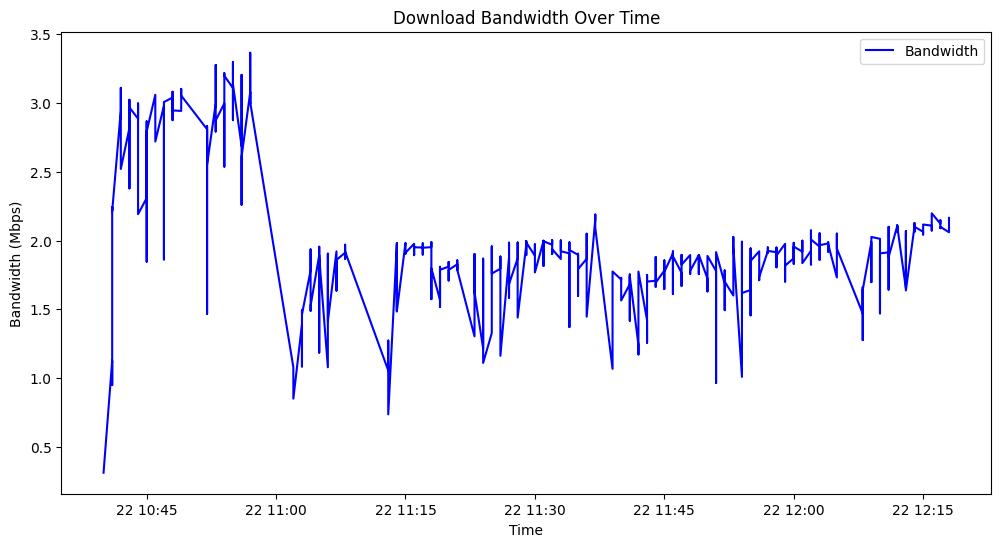

In [27]:
# Convert 'Local time' to datetime if available
if 'Local time' in gmeet_data.columns:
    gmeet_data['Local time'] = pd.to_datetime(gmeet_data['Local time'])

# Plot bandwidth over time
if 'Local time' in gmeet_data.columns:
    plt.figure(figsize=(12, 6))
    plt.plot(gmeet_data['Local time'], gmeet_data['Download (Rx) bandwidth (Mbps)'], color='blue', label='Bandwidth')
    plt.title('Download Bandwidth Over Time')
    plt.xlabel('Time')
    plt.ylabel('Bandwidth (Mbps)')
    plt.legend()
    plt.show()
else:
    print("Local time column not available for time-series plotting.")



* ### The plot shows noticeable fluctuations in download bandwidth over time, with several drops below 1 Mbps.
* ### Bandwidth drops below 2 Mbps, particularly during video conferencing, can degrade quality by causing buffering, pixelation, or delays.


### Jitter Over Time

### The code visualizes how the Rx instant jitter metric changes over time to assess network stability for received packets.

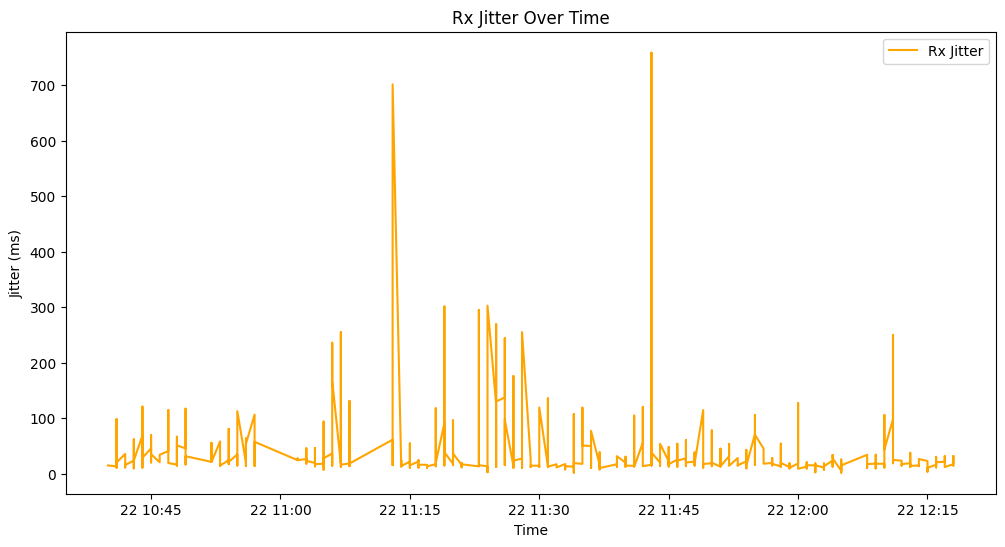

In [28]:
# Plot jitter over time
if 'Local time' in gmeet_data.columns:
    plt.figure(figsize=(12, 6))
    plt.plot(gmeet_data['Local time'], gmeet_data['Rx instant jitter (ms)'], color='orange', label='Rx Jitter')
    plt.title('Rx Jitter Over Time')
    plt.xlabel('Time')
    plt.ylabel('Jitter (ms)')
    plt.legend()
    plt.show()
else:
    print("Local time column not available for time-series plotting.")



* ### The jitter plot reveals frequent fluctuations with some significant spikes exceeding 700 ms, indicating intermittent network instability.
* ### High jitter values, especially above the ITU-T G.1010 threshold of 30 ms for conversational applications, suggest potential disruptions in video quality, such as delays or audio-video desynchronization.


# 🎯| Deriving Target Variable 

##  Threshold-Based Target Derivation

### Define Thresholds and Apply Categorization

In [29]:
import pandas as pd
import numpy as np

# Load the dataset
gmeet_data = pd.read_csv('/kaggle/input/pre-processed-datasets/gmeet480p_preprocessed.csv')

# Define ITU-T thresholds for QoS metrics
thresholds = {
    'Rx packet loss (percent)': [1, 3],  # Good (<1%), Fair (1-3%), Poor (>3%)
    'Tx packet loss (percent)': [1, 3],
    'RTT (ping) (ms)': [150, 300],      # Good (<150ms), Fair (150-300ms), Poor (>300ms)
    'Rx instant jitter (ms)': [30, 50], # Good (<30ms), Fair (30-50ms), Poor (>50ms)
    'Tx instant jitter (ms)': [30, 50]
}

# Function to assign thresholds
def assign_labels(row, metric, threshold):
    if row[metric] < threshold[0]:
        return 'Good'
    elif threshold[0] <= row[metric] <= threshold[1]:
        return 'Fair'
    else:
        return 'Poor'

# Apply thresholds to derive labels
for metric, threshold in thresholds.items():
    gmeet_data[f'{metric}_label'] = gmeet_data.apply(assign_labels, axis=1, metric=metric, threshold=threshold)

# Aggregate individual metric labels into an overall QoE label
def majority_vote(row):
    labels = [row[f'{metric}_label'] for metric in thresholds.keys()]
    return max(set(labels), key=labels.count)

gmeet_data['Initial_QoE'] = gmeet_data.apply(majority_vote, axis=1)


# View the dataset with categorized metrics
gmeet_data.head()


,Local time,Rx packet loss (percent),Tx packet loss (percent),RTT (ping) (ms),Rx instant jitter (ms),Tx instant jitter (ms),Mean Jitter,Jitter Difference,Download (Rx) bandwidth (Mbps),Upload (Tx) bandwidth (Mbps),Elapsed Time,Is Outlier,Service,Rx packet loss (percent)_label,Tx packet loss (percent)_label,RTT (ping) (ms)_label,Rx instant jitter (ms)_label,Tx instant jitter (ms)_label,Initial_QoE
0,2023-11-22 10:40:00,0.0,3.495360,247.14151,14.5945,34.443000,24.518750,-19.848500,0.312022,0.317488,0.0,True,Gmeet,Good,Poor,Fair,Good,Fair,Fair
1,2023-11-22 10:41:00,0.0,0.267198,239.12780,12.7749,23.908998,18.341949,-11.134099,1.127387,0.315106,60.0,False,Gmeet,Good,Good,Fair,Good,Good,Good
2,2023-11-22 10:41:00,0.0,0.208341,239.12780,17.4039,125.338490,71.371195,-107.934590,1.096868,0.553769,60.0,False,Gmeet,Good,Good,Fair,Good,Poor,Good
3,2023-11-22 10:41:00,0.0,22.026150,494.98760,10.4337,118.812000,64.622850,-108.378300,1.829561,0.989093,60.0,False,Gmeet,Good,Poor,Poor,Good,Poor,Poor
4,2023-11-22 10:41:00,0.0,5.532537,622.78280,19.6253,124.265900,71.945600,-104.640600,2.243818,1.055930,60.0,False,Gmeet,Good,Poor,Poor,Good,Poor,Poor


## Semi-Supervised Clustering

### Normalize Data and Initialize K-Means

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select QoS metrics for clustering
qos_features = ['Rx packet loss (percent)', 'Tx packet loss (percent)', 
                'RTT (ping) (ms)', 'Rx instant jitter (ms)', 'Tx instant jitter (ms)']

# Standardize QoS features
scaler = StandardScaler()
qos_scaled = scaler.fit_transform(gmeet_data[qos_features])

# Compute initial cluster centers based on threshold-based labels
initial_centers = gmeet_data.groupby('Initial_QoE')[qos_features].mean()

# K-Means clustering with initialized cluster centers
kmeans = KMeans(n_clusters=3, init=initial_centers.values, n_init=1)
gmeet_data['Cluster_QoE'] = kmeans.fit_predict(qos_scaled)

# Map cluster labels to string equivalents
cluster_label_mapping = {0: 'Good', 1: 'Fair', 2: 'Poor'}  # Adjust based on your clustering results
gmeet_data['Cluster_QoE_mapped'] = gmeet_data['Cluster_QoE'].map(cluster_label_mapping)

gmeet_data.head()


,Local time,Rx packet loss (percent),Tx packet loss (percent),RTT (ping) (ms),Rx instant jitter (ms),Tx instant jitter (ms),Mean Jitter,Jitter Difference,Download (Rx) bandwidth (Mbps),Upload (Tx) bandwidth (Mbps),...,Is Outlier,Service,Rx packet loss (percent)_label,Tx packet loss (percent)_label,RTT (ping) (ms)_label,Rx instant jitter (ms)_label,Tx instant jitter (ms)_label,Initial_QoE,Cluster_QoE,Cluster_QoE_mapped
0,2023-11-22 10:40:00,0.0,3.495360,247.14151,14.5945,34.443000,24.518750,-19.848500,0.312022,0.317488,...,True,Gmeet,Good,Poor,Fair,Good,Fair,Fair,2,Poor
1,2023-11-22 10:41:00,0.0,0.267198,239.12780,12.7749,23.908998,18.341949,-11.134099,1.127387,0.315106,...,False,Gmeet,Good,Good,Fair,Good,Good,Good,2,Poor
2,2023-11-22 10:41:00,0.0,0.208341,239.12780,17.4039,125.338490,71.371195,-107.934590,1.096868,0.553769,...,False,Gmeet,Good,Good,Fair,Good,Poor,Good,2,Poor
3,2023-11-22 10:41:00,0.0,22.026150,494.98760,10.4337,118.812000,64.622850,-108.378300,1.829561,0.989093,...,False,Gmeet,Good,Poor,Poor,Good,Poor,Poor,2,Poor
4,2023-11-22 10:41:00,0.0,5.532537,622.78280,19.6253,124.265900,71.945600,-104.640600,2.243818,1.055930,...,False,Gmeet,Good,Poor,Poor,Good,Poor,Poor,2,Poor


## Ensemble Target Derivation

###  Combine Results from Threshold-Based and Clustering-Based Methods

In [31]:
from sklearn.metrics import cohen_kappa_score

# Function to ensemble labels
def ensemble_labels(row):
    if row['Initial_QoE'] == row['Cluster_QoE_mapped']:
        return row['Initial_QoE']
    else:
        return row['Cluster_QoE_mapped']  # Prioritize clustering-based labels in conflicts

# Add ensembled target variable
gmeet_data['Final_QoE'] = gmeet_data.apply(ensemble_labels, axis=1)

# Evaluate consistency between methods
consistency_score = cohen_kappa_score(gmeet_data['Initial_QoE'], gmeet_data['Cluster_QoE_mapped'])
print(f"Consistency Score between Threshold-Based and Clustering-Based Labels: {consistency_score}")

gmeet_data.head()



Consistency Score between Threshold-Based and Clustering-Based Labels: 0.24433534743202412


,Local time,Rx packet loss (percent),Tx packet loss (percent),RTT (ping) (ms),Rx instant jitter (ms),Tx instant jitter (ms),Mean Jitter,Jitter Difference,Download (Rx) bandwidth (Mbps),Upload (Tx) bandwidth (Mbps),...,Service,Rx packet loss (percent)_label,Tx packet loss (percent)_label,RTT (ping) (ms)_label,Rx instant jitter (ms)_label,Tx instant jitter (ms)_label,Initial_QoE,Cluster_QoE,Cluster_QoE_mapped,Final_QoE
0,2023-11-22 10:40:00,0.0,3.495360,247.14151,14.5945,34.443000,24.518750,-19.848500,0.312022,0.317488,...,Gmeet,Good,Poor,Fair,Good,Fair,Fair,2,Poor,Poor
1,2023-11-22 10:41:00,0.0,0.267198,239.12780,12.7749,23.908998,18.341949,-11.134099,1.127387,0.315106,...,Gmeet,Good,Good,Fair,Good,Good,Good,2,Poor,Poor
2,2023-11-22 10:41:00,0.0,0.208341,239.12780,17.4039,125.338490,71.371195,-107.934590,1.096868,0.553769,...,Gmeet,Good,Good,Fair,Good,Poor,Good,2,Poor,Poor
3,2023-11-22 10:41:00,0.0,22.026150,494.98760,10.4337,118.812000,64.622850,-108.378300,1.829561,0.989093,...,Gmeet,Good,Poor,Poor,Good,Poor,Poor,2,Poor,Poor
4,2023-11-22 10:41:00,0.0,5.532537,622.78280,19.6253,124.265900,71.945600,-104.640600,2.243818,1.055930,...,Gmeet,Good,Poor,Poor,Good,Poor,Poor,2,Poor,Poor


In [32]:
# Check counts for threshold-based labels (Initial_QoE)
print("Counts for Threshold-Based Labels (Initial_QoE):")
threshold_counts = gmeet_data['Initial_QoE'].value_counts()
print(threshold_counts)

# Check counts for clustering-based labels (Cluster_QoE_mapped)
print("\nCounts for Clustering-Based Labels (Cluster_QoE_mapped):")
clustering_counts = gmeet_data['Cluster_QoE_mapped'].value_counts()
print(clustering_counts)


Counts for Threshold-Based Labels (Initial_QoE):
Initial_QoE
Poor    475
Good    171
Fair     21
Name: count, dtype: int64

Counts for Clustering-Based Labels (Cluster_QoE_mapped):
Cluster_QoE_mapped
Poor    469
Good    182
Fair     16
Name: count, dtype: int64


In [33]:
# Compare Initial_QoE and Cluster_QoE_mapped
mismatches = gmeet_data[gmeet_data['Initial_QoE'] != gmeet_data['Cluster_QoE_mapped']]
print(f"Number of mismatches: {len(mismatches)}")
print(mismatches[['Initial_QoE', 'Cluster_QoE_mapped']].head())


Number of mismatches: 216
  Initial_QoE Cluster_QoE_mapped
0        Fair               Poor
1        Good               Poor
2        Good               Poor
5        Poor               Good
7        Good               Poor


## Evaluate and Compare Methods

Feature-Target Correlation:
Rx packet loss (percent)    0.046969
Tx packet loss (percent)    0.786992
RTT (ping) (ms)             0.553725
Rx instant jitter (ms)      0.179377
Tx instant jitter (ms)     -0.446827
Final_QoE_numeric           1.000000
Name: Final_QoE_numeric, dtype: float64

Clustering Quality Metrics:
Silhouette Score: 0.3548820170953026
Davies-Bouldin Index: 1.2460367212652501
Calinski-Harabasz Index: 198.9201616460176


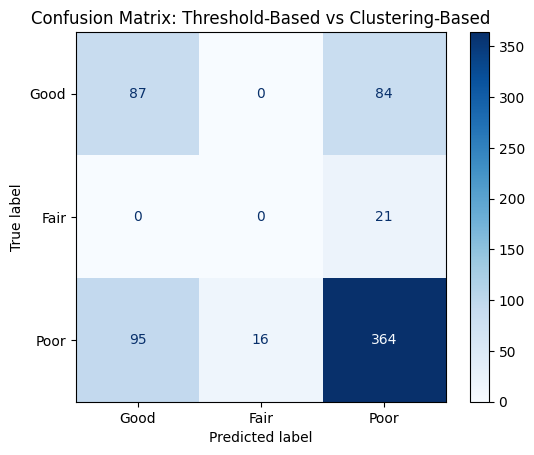

In [34]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, confusion_matrix, ConfusionMatrixDisplay

# Encode Final_QoE to numeric values
qoe_mapping = {'Good': 2, 'Fair': 1, 'Poor': 0}
gmeet_data['Final_QoE_numeric'] = gmeet_data['Final_QoE'].map(qoe_mapping)

# Correlation analysis
correlations = gmeet_data[qos_features + ['Final_QoE_numeric']].corr()
print("Feature-Target Correlation:")
print(correlations['Final_QoE_numeric'])

# Clustering quality metrics
silhouette = silhouette_score(qos_scaled, gmeet_data['Cluster_QoE'])
davies_bouldin = davies_bouldin_score(qos_scaled, gmeet_data['Cluster_QoE'])
calinski_harabasz = calinski_harabasz_score(qos_scaled, gmeet_data['Cluster_QoE'])

print(f"\nClustering Quality Metrics:")
print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Index: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

# Confusion Matrix for Initial vs Cluster
conf_matrix = confusion_matrix(gmeet_data['Initial_QoE'], gmeet_data['Cluster_QoE_mapped'], labels=['Good', 'Fair', 'Poor'])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Good', 'Fair', 'Poor'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: Threshold-Based vs Clustering-Based")
plt.show()


##  Consolidate Results and Select the Best Method

In [35]:
# Consolidate evaluation metrics
evaluation_results = {
    'Feature-Target Correlation': correlations['Final_QoE_numeric'],
    'Silhouette Score': silhouette,
    'Davies-Bouldin Index': davies_bouldin,
    'Calinski-Harabasz Index': calinski_harabasz
}

print("\nEvaluation Results:")
for metric, value in evaluation_results.items():
    print(f"{metric}: {value}")

# Select final target variable
if silhouette > 0.5 and evaluation_results['Feature-Target Correlation'].mean() > 0.6:
    final_target = gmeet_data['Final_QoE_numeric']
    print("\nSelected Final Target Variable: Final_QoE (Ensembled)")
elif silhouette > 0.5:
    final_target = gmeet_data['Cluster_QoE']
    print("\nSelected Final Target Variable: Cluster_QoE")
else:
    final_target = gmeet_data['Initial_QoE']
    print("\nSelected Final Target Variable: Initial_QoE")

# Save the final target variable for the dataset
gmeet_data['Final_Selected_Target'] = final_target

gmeet_data.head()



Evaluation Results:
Feature-Target Correlation: Rx packet loss (percent)    0.046969
Tx packet loss (percent)    0.786992
RTT (ping) (ms)             0.553725
Rx instant jitter (ms)      0.179377
Tx instant jitter (ms)     -0.446827
Final_QoE_numeric           1.000000
Name: Final_QoE_numeric, dtype: float64
Silhouette Score: 0.3548820170953026
Davies-Bouldin Index: 1.2460367212652501
Calinski-Harabasz Index: 198.9201616460176

Selected Final Target Variable: Initial_QoE


,Local time,Rx packet loss (percent),Tx packet loss (percent),RTT (ping) (ms),Rx instant jitter (ms),Tx instant jitter (ms),Mean Jitter,Jitter Difference,Download (Rx) bandwidth (Mbps),Upload (Tx) bandwidth (Mbps),...,Tx packet loss (percent)_label,RTT (ping) (ms)_label,Rx instant jitter (ms)_label,Tx instant jitter (ms)_label,Initial_QoE,Cluster_QoE,Cluster_QoE_mapped,Final_QoE,Final_QoE_numeric,Final_Selected_Target
0,2023-11-22 10:40:00,0.0,3.495360,247.14151,14.5945,34.443000,24.518750,-19.848500,0.312022,0.317488,...,Poor,Fair,Good,Fair,Fair,2,Poor,Poor,0,Fair
1,2023-11-22 10:41:00,0.0,0.267198,239.12780,12.7749,23.908998,18.341949,-11.134099,1.127387,0.315106,...,Good,Fair,Good,Good,Good,2,Poor,Poor,0,Good
2,2023-11-22 10:41:00,0.0,0.208341,239.12780,17.4039,125.338490,71.371195,-107.934590,1.096868,0.553769,...,Good,Fair,Good,Poor,Good,2,Poor,Poor,0,Good
3,2023-11-22 10:41:00,0.0,22.026150,494.98760,10.4337,118.812000,64.622850,-108.378300,1.829561,0.989093,...,Poor,Poor,Good,Poor,Poor,2,Poor,Poor,0,Poor
4,2023-11-22 10:41:00,0.0,5.532537,622.78280,19.6253,124.265900,71.945600,-104.640600,2.243818,1.055930,...,Poor,Poor,Good,Poor,Poor,2,Poor,Poor,0,Poor


In [36]:
# Check counts for threshold-based labels (Initial_QoE)
print("Counts for Threshold-Based Labels (Initial_QoE):")
threshold_counts = gmeet_data['Final_Selected_Target'].value_counts()
print(threshold_counts)


Counts for Threshold-Based Labels (Initial_QoE):
Final_Selected_Target
Poor    475
Good    171
Fair     21
Name: count, dtype: int64


## Finalize and Save Dataset

In [37]:
# Save the dataset with Final QoE labels
gmeet_data.to_csv('/kaggle/working/gmeet_final_qoe.csv', index=False)
print("Final dataset with derived QoE labels saved as 'gmeet_final_qoe.csv'")


Final dataset with derived QoE labels saved as 'gmeet_final_qoe.csv'


# ⚙️| Feature Engineering